In [1]:
!pip install optuna
!pip install optuna-dashboard
!pip install optuna-integration


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install plotly


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.core import XGBoostError
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from optuna.integration import XGBoostPruningCallback

import optuna.visualization as vis


import csv

import cupy as cp

import gc

In [4]:
df = pd.read_csv("../../story_dataset.csv")
df

prompt_id                                 prompt  \
0             1    Once upon a time there was a dragon   
1             1    Once upon a time there was a dragon   
2             1    Once upon a time there was a dragon   
3             1    Once upon a time there was a dragon   
4             1    Once upon a time there was a dragon   
...         ...                                    ...   
9995         10  Once upon a time there was a poor boy   
9996         10  Once upon a time there was a poor boy   
9997         10  Once upon a time there was a poor boy   
9998         10  Once upon a time there was a poor boy   
9999         10  Once upon a time there was a poor boy   

                                                  story  \
0     Once upon a time there was a dragon. It was bi...   
1     Once upon a time there was a dragon. He loved ...   
2     Once upon a time there was a dragon named Sam....   
3     Once upon a time there was a dragon. He was a ...   
4     Once upon a time there was a dragon. The drago...   
...                                                 ...   
9995  Once upon a time there was a poor boy named Ti...   
9996  Once upon a time there was a poor boy named Ti...   
9997  Once upon a time there was a poor boy named Ti...   
9998  Once upon a time there was a poor boy named Ti...   
9999  Once upon a time there was a poor boy named Ti...   

                  hidden_state_file  len_generated_story  
0      ./hidden_states/prompt_1.npz                  273  
1      ./hidden_states/prompt_1.npz                  246  
2      ./hidden_states/prompt_1.npz                  397  
3      ./hidden_states/prompt_1.npz                  294  
4      ./hidden_states/prompt_1.npz                  296  
...                             ...                  ...  
9995  ./hidden_states/prompt_10.npz                  315  
9996  ./hidden_states/prompt_10.npz                  270  
9997  ./hidden_states/prompt_10.npz                  206  
9998  ./hidden_states/prompt_10.npz                  375  
9999  ./hidden_states/prompt_10.npz                  341  

[10000 rows x 5 columns]

In [5]:
# hidden_states_by_layer = {}
# curr_labels = []
# NUM_PROMPTS = 10
# # NUM_PROMPTS = 2
# context_level = 49

# #Load hidden states to generate first token
# for prompt_id in range(1, NUM_PROMPTS + 1):
#     with np.load(f'../../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
#         for i in tqdm(range(1000)):
#             curr_hidden_states = loaded_data[f"arr_{i}"]
#             # print(curr_hidden_states.shape)
#             if(context_level > curr_hidden_states.shape[0]):
#                 continue

#             curr_hidden_states = curr_hidden_states[context_level]
#             curr_labels.append(df.iloc[i * prompt_id].prompt_id)
            
#             #By layer
#             for layer in range(1):
#                 curr_layer_hidden_states = curr_hidden_states[layer][0].astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 # print(curr_layer_hidden_states.shape)
                
#                 if(f"layer_{layer}" in hidden_states_by_layer):
#                     hidden_states_by_layer[f"layer_{layer}"].append(curr_layer_hidden_states)
#                 else:
#                     hidden_states_by_layer[f"layer_{layer}"] = [curr_layer_hidden_states]

In [6]:
hidden_states_by_cl = {}
curr_labels = {}
NUM_PROMPTS = 10
layer = 1

In [7]:
max_story_len = max(df[:NUM_PROMPTS*1000]["len_generated_story"])
max_story_len

522

In [8]:
df[df["len_generated_story"] >= max_story_len]

prompt_id                                 prompt  \
9851         10  Once upon a time there was a poor boy   

                                                  story  \
9851  Once upon a time there was a poor boy named Ti...   

                  hidden_state_file  len_generated_story  
9851  ./hidden_states/prompt_10.npz                  522

In [9]:
min_story_len = min(df["len_generated_story"])
min_story_len

37

In [10]:
context_levels = [0] #get hs used to generate second token
context_levels.extend([i for i in range(23, max_story_len, 25)]) #actual context level is context_level + 2 (gather hs to generate the context_level + 2 token)

In [11]:
# #results using hs to generate first token already captured in other notebook
# #get hs to generate second token, 25th token, 50th token, etc.

# #Load hidden states to generate first token
# for prompt_id in range(1, NUM_PROMPTS + 1):
#     with np.load(f'../../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
#         for i in tqdm(range(1000)):
#             for context_level in context_levels:
#                 curr_hidden_states = loaded_data[f"arr_{i}"]
#                 # print(curr_hidden_states.shape)
#                 if(context_level > curr_hidden_states.shape[0] - 1):
#                     continue
                
#                 curr_hidden_states = curr_hidden_states[context_level][layer][0].astype('float32')
                
#                 if(f"cl_{context_level + 2}" in hidden_states_by_cl):
#                     hidden_states_by_cl[f"cl_{context_level + 2}"].append(curr_hidden_states)
#                     curr_labels[f"cl_{context_level + 2}"].append(df.iloc[i * prompt_id].prompt_id)
#                 else:
#                     hidden_states_by_cl[f"cl_{context_level + 2}"] = [curr_hidden_states]
#                     curr_labels[f"cl_{context_level + 2}"] = [df.iloc[i * prompt_id].prompt_id]

In [12]:
hidden_states_by_cl = {f"cl_{cl+2}": [] for cl in context_levels}
curr_labels = {f"cl_{cl+2}": [] for cl in context_levels}

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../../../llamatales-xgboost-ii/hidden_states/prompt_{prompt_id}.npz') as loaded_data:

        for i in tqdm(range(1000)):
            hs = loaded_data[f"arr_{i}"]  # load once

            for context_level in context_levels:
                if context_level >= hs.shape[0]:
                    continue

                key = f"cl_{context_level + 2}"

                hidden_states_by_cl[key].append(
                    hs[context_level][layer][0].astype("float32")
                )
                curr_labels[key].append(prompt_id - 1)


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.32it/s]


In [13]:
def safe_split(total, train_ratio=0.8):
    train = int(train_ratio * total)   # floor
    test  = total - train              # leftover
    return train, test

def build_dataset(curr_context_level_hs, curr_labels, train_ratio=0.8):
    """
    Groups samples by prompt_id, splits safely into train/test,
    and returns X_train, y_train, X_test, y_test.
    """

    unique_ids = sorted(set(curr_labels))

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for pid in unique_ids:

        # get samples for this prompt id
        mask = (curr_labels == pid)
        X_pid = curr_context_level_hs[mask]
        y_pid = curr_labels[mask]

        total = len(X_pid)
        train_n, test_n = safe_split(total, train_ratio)

        # split
        X_train_list.append(X_pid[:train_n])
        y_train_list.append(y_pid[:train_n])

        X_test_list.append(X_pid[train_n:])
        y_test_list.append(y_pid[train_n:])

    # concatenate all prompt-id blocks
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_test  = np.concatenate(X_test_list, axis=0)
    y_test  = np.concatenate(y_test_list, axis=0)

    # return cp.array(X_train), cp.array(y_train), cp.array(X_test), cp.array(y_test)
    return X_train, y_train, X_test, y_test
    

In [14]:
np.array(hidden_states_by_cl[f"cl_2"]).shape

(10000, 1, 512)

In [15]:
print(np.array(curr_labels[f"cl_2"]).shape)

(10000,)


In [16]:
# Defining the objective function
def objective(trial):
    # param = {
    #     'max_depth': trial.suggest_int('max_depth', 3, 10),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    #     'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    #     'gamma': trial.suggest_float('gamma', 0, 5),
    # }

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 25, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 0.75),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.75),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'lambda': trial.suggest_float('lambda', 1, 10),
    }
    
    # initializing the XGBoost model
    model = xgb.XGBClassifier(**param,
                              seed = 42, #for reproducibility
                              objective = 'multi:softmax',
                              eval_metric = "merror",
                              num_class = len(unique_ids),
                              tree_method = 'hist',  # GPU training
                              device = 'cuda')       # specify the GPU ID if multi-GPU
    model.fit(X_train_opt, y_train_opt)

    # pruning_callback = XGBoostPruningCallback(trial, "validation_0-merror")
    
    # model.fit(
    #     X_train, y_train,
    #     eval_set=[(X_valid, y_valid)],
    #     callbacks=[pruning_callback],
    #     verbose=False
    # )

    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid.get(), preds)
    # preds = model.predict(X_test)
    # accuracy = accuracy_score(y_test.get(), preds)
    return accuracy

In [17]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

Optimizing Layer 1 at Context Level 25
(10000, 1, 512)
(10000, 512)
0    800
1    800
2    800
3    800
4    800
5    800
6    800
7    800
8    800
9    800
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
6    654
4    653
2    642
9    642
3    639
5    639
8    635
1    634
7    634
0    628
Name: count, dtype: int64
0    172
1    166
7    166
8    165
3    161
5    161
2    158
9    158
4    147
6    146
Name: count, dtype: int64
Train Data Shape:  (8000, 512)
Test Data Shape:  (2000, 512)
Optimizer Train Data Shape:  (6400, 512)


[I 2026-02-14 03:51:49,028] A new study created in memory with name: no-name-251ff7bc-e42e-4088-85ec-449c5e9f1e86


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 03:51:57,706] Trial 4 finished with value: 0.270625 and parameters: {'max_depth': 2, 'learning_rate': 0.08808309730141407, 'n_estimators': 82, 'subsample': 0.5086092663958812, 'colsample_bytree': 0.6702866931759751, 'min_child_weight': 17, 'gamma': 9.097671372056853, 'alpha': 0.23380961244278908, 'lambda': 4.599598334994166}. Best is trial 4 with value: 0.270625.
[I 2026-02-14 03:51:59,999] Trial 13 finished with value: 0.22 and parameters: {'max_depth': 1, 'learning_rate': 0.05096023921681251, 'n_estimators': 74, 'subsample': 0.7339689258638356, 'colsample_bytree': 0.5064409083212948, 'min_child_weight': 16, 'gamma': 5.672882239103623, 'alpha': 7.887875894791977, 'lambda': 4.3659997548698115}. Best is trial 4 with value: 0.270625.
[I 2026-02-14 03:52:04,001] Trial 6 finished with value: 0.26 and parameters: {'max_depth': 3, 'learning_rate': 0.010166502827737506, 'n_estimators': 84, 'subsample': 0.7125705083447708, 'colsample_bytree': 0.596284898832617, 'min_child_weight'

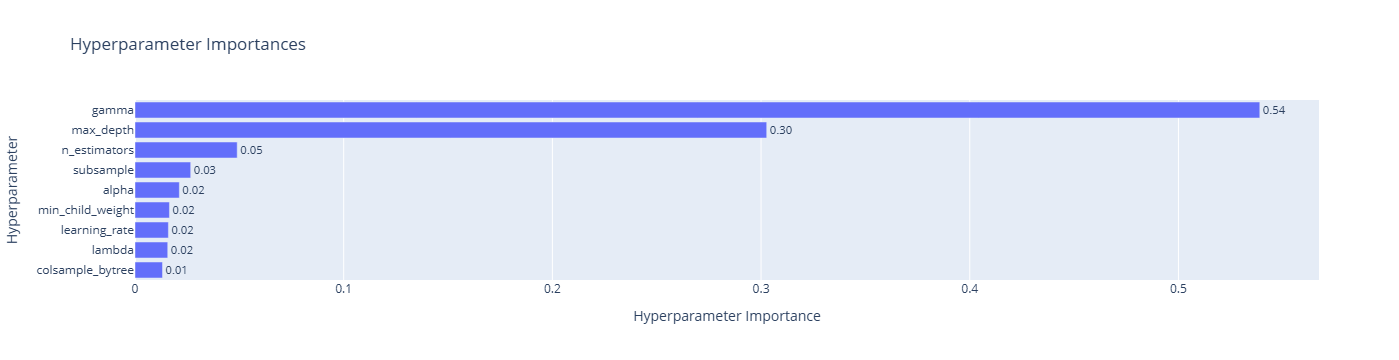

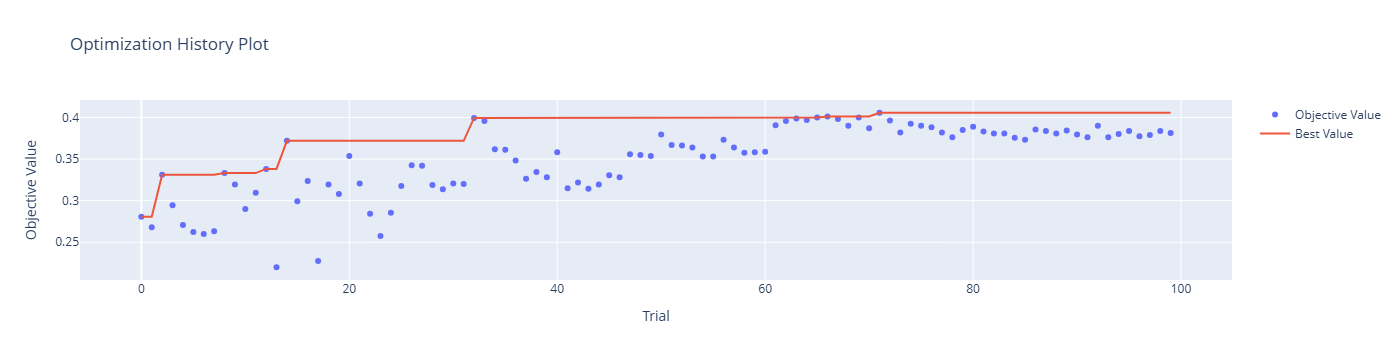

Best trial: 0.405625
Best params: {'max_depth': 5, 'learning_rate': 0.08360070404023655, 'n_estimators': 594, 'subsample': 0.7062276494377473, 'colsample_bytree': 0.6395569027837467, 'min_child_weight': 9, 'gamma': 0.08466329975850928, 'alpha': 3.7633536548800994, 'lambda': 3.643156155374444}
Train Accuracy: 0.997875
Test Accuracy: 0.4415
Prompt 1 Train Accuracy: 0.9975
Prompt 1 Test Accuracy: 0.475
Prompt 2 Train Accuracy: 0.9925
Prompt 2 Test Accuracy: 0.335
Prompt 3 Train Accuracy: 1.0
Prompt 3 Test Accuracy: 0.525
Prompt 4 Train Accuracy: 0.9975
Prompt 4 Test Accuracy: 0.36
Prompt 5 Train Accuracy: 1.0
Prompt 5 Test Accuracy: 0.51
Prompt 6 Train Accuracy: 1.0
Prompt 6 Test Accuracy: 0.425
Prompt 7 Train Accuracy: 0.99875
Prompt 7 Test Accuracy: 0.38
Prompt 8 Train Accuracy: 0.99875
Prompt 8 Test Accuracy: 0.465
Prompt 9 Train Accuracy: 0.995
Prompt 9 Test Accuracy: 0.385
Prompt 10 Train Accuracy: 0.99875
Prompt 10 Test Accuracy: 0.555
Optimizing Layer 1 at Context Level 50
(9999, 1

[I 2026-02-14 04:05:00,223] A new study created in memory with name: no-name-504d1f28-1355-4764-876d-dee1fbb82d3e


(9999, 512)
0    800
1    800
2    800
3    800
4    800
5    800
7    800
8    800
9    800
6    799
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
9    654
5    646
4    645
2    642
8    640
3    638
6    636
7    636
1    634
0    628
Name: count, dtype: int64
0    172
1    166
7    164
6    163
3    162
8    160
2    158
4    155
5    154
9    146
Name: count, dtype: int64
Train Data Shape:  (7999, 512)
Test Data Shape:  (2000, 512)
Optimizer Train Data Shape:  (6399, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 04:05:52,238] Trial 10 finished with value: 0.29375 and parameters: {'max_depth': 2, 'learning_rate': 0.03924993376636743, 'n_estimators': 419, 'subsample': 0.5888285044953002, 'colsample_bytree': 0.5629613880634234, 'min_child_weight': 8, 'gamma': 4.305698624726627, 'alpha': 3.919181167911552, 'lambda': 9.912659331613131}. Best is trial 10 with value: 0.29375.
[I 2026-02-14 04:05:53,620] Trial 5 finished with value: 0.2975 and parameters: {'max_depth': 4, 'learning_rate': 0.09648718549905282, 'n_estimators': 341, 'subsample': 0.6770866746036263, 'colsample_bytree': 0.5420167247600207, 'min_child_weight': 13, 'gamma': 3.05907587872001, 'alpha': 6.6297894645560485, 'lambda': 2.581336279156149}. Best is trial 5 with value: 0.2975.
[I 2026-02-14 04:05:56,069] Trial 12 finished with value: 0.285 and parameters: {'max_depth': 1, 'learning_rate': 0.07852725804570494, 'n_estimators': 613, 'subsample': 0.6687675410124025, 'colsample_bytree': 0.6823473139548587, 'min_child_weight'

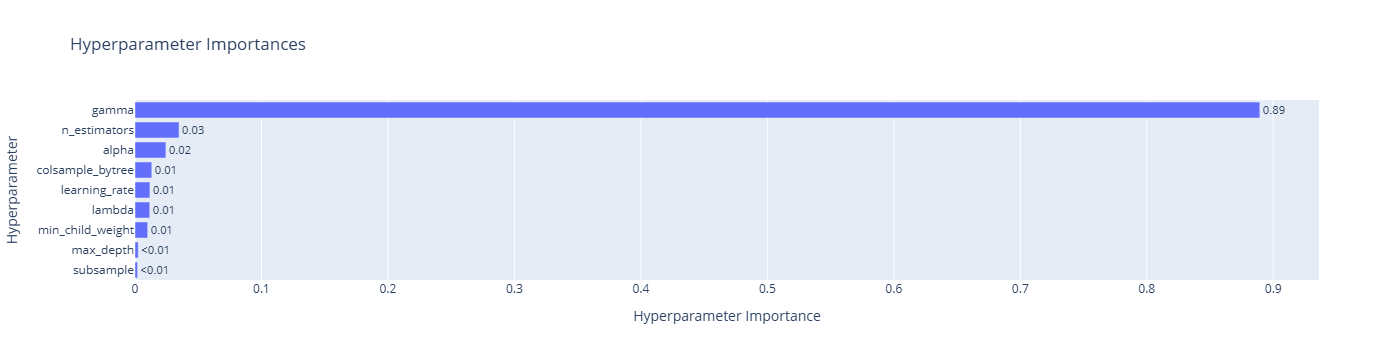

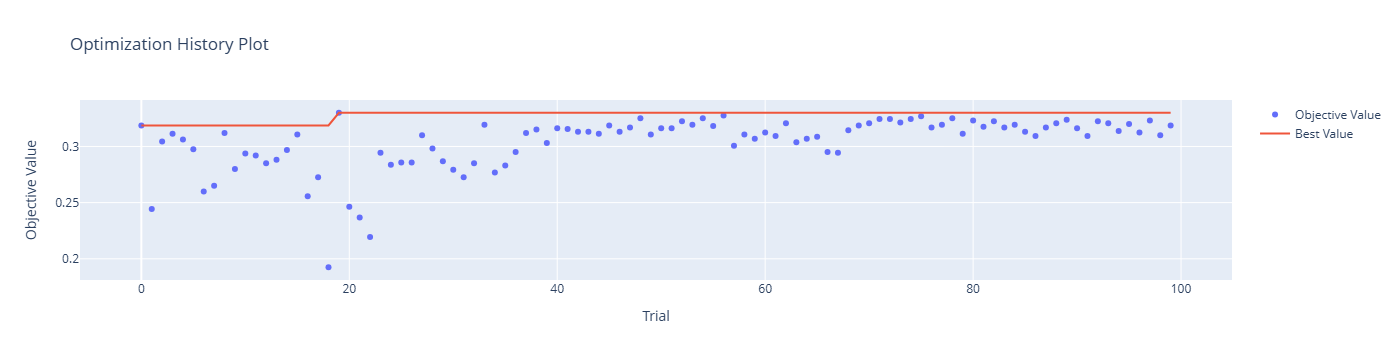

Best trial: 0.33
Best params: {'max_depth': 6, 'learning_rate': 0.08124715545295194, 'n_estimators': 508, 'subsample': 0.667034827361032, 'colsample_bytree': 0.6720326251552584, 'min_child_weight': 8, 'gamma': 0.24647964160898317, 'alpha': 6.324084012288025, 'lambda': 4.187888075108392}
Train Accuracy: 0.9872484060507564
Test Accuracy: 0.3345
Prompt 1 Train Accuracy: 0.98875
Prompt 1 Test Accuracy: 0.36
Prompt 2 Train Accuracy: 0.9925
Prompt 2 Test Accuracy: 0.275
Prompt 3 Train Accuracy: 0.9875
Prompt 3 Test Accuracy: 0.4
Prompt 4 Train Accuracy: 0.98
Prompt 4 Test Accuracy: 0.23
Prompt 5 Train Accuracy: 0.9875
Prompt 5 Test Accuracy: 0.41
Prompt 6 Train Accuracy: 0.98375
Prompt 6 Test Accuracy: 0.305
Prompt 7 Train Accuracy: 0.9849812265331664
Prompt 7 Test Accuracy: 0.33
Prompt 8 Train Accuracy: 0.99625
Prompt 8 Test Accuracy: 0.34
Prompt 9 Train Accuracy: 0.9825
Prompt 9 Test Accuracy: 0.315
Prompt 10 Train Accuracy: 0.98875
Prompt 10 Test Accuracy: 0.38


[I 2026-02-14 04:19:12,073] A new study created in memory with name: no-name-28a5ebd1-0aef-419f-a0c4-d788e6ab4dd4


Optimizing Layer 1 at Context Level 75
(9999, 1, 512)
(9999, 512)
0    800
1    800
2    800
3    800
4    800
5    800
7    800
8    800
9    800
6    799
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
9    654
5    646
4    645
2    642
8    640
3    638
6    636
7    636
1    634
0    628
Name: count, dtype: int64
0    172
1    166
7    164
6    163
3    162
8    160
2    158
4    155
5    154
9    146
Name: count, dtype: int64
Train Data Shape:  (7999, 512)
Test Data Shape:  (2000, 512)
Optimizer Train Data Shape:  (6399, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 04:19:35,362] Trial 10 finished with value: 0.19375 and parameters: {'max_depth': 3, 'learning_rate': 0.0694532087517424, 'n_estimators': 243, 'subsample': 0.6907013908066506, 'colsample_bytree': 0.7472133016317242, 'min_child_weight': 11, 'gamma': 9.392007326214229, 'alpha': 9.541638490172593, 'lambda': 6.466118008569121}. Best is trial 10 with value: 0.19375.
[I 2026-02-14 04:19:40,962] Trial 8 finished with value: 0.25875 and parameters: {'max_depth': 6, 'learning_rate': 0.06185209583494899, 'n_estimators': 186, 'subsample': 0.5840894177164961, 'colsample_bytree': 0.6077473614672843, 'min_child_weight': 10, 'gamma': 7.175253171246979, 'alpha': 0.9070749290805413, 'lambda': 1.2261054609439106}. Best is trial 8 with value: 0.25875.
[I 2026-02-14 04:19:42,473] Trial 6 finished with value: 0.246875 and parameters: {'max_depth': 2, 'learning_rate': 0.037152109939376114, 'n_estimators': 278, 'subsample': 0.6332205242013198, 'colsample_bytree': 0.5699378469628074, 'min_child_

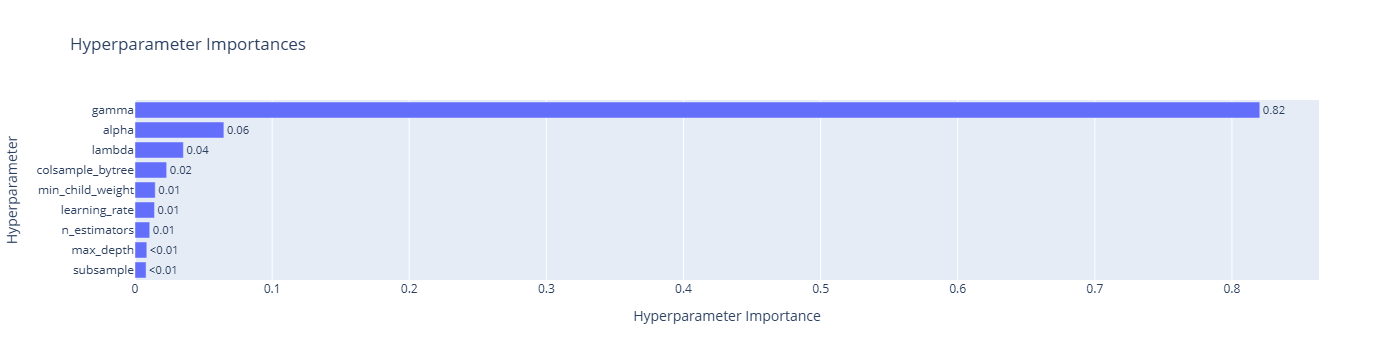

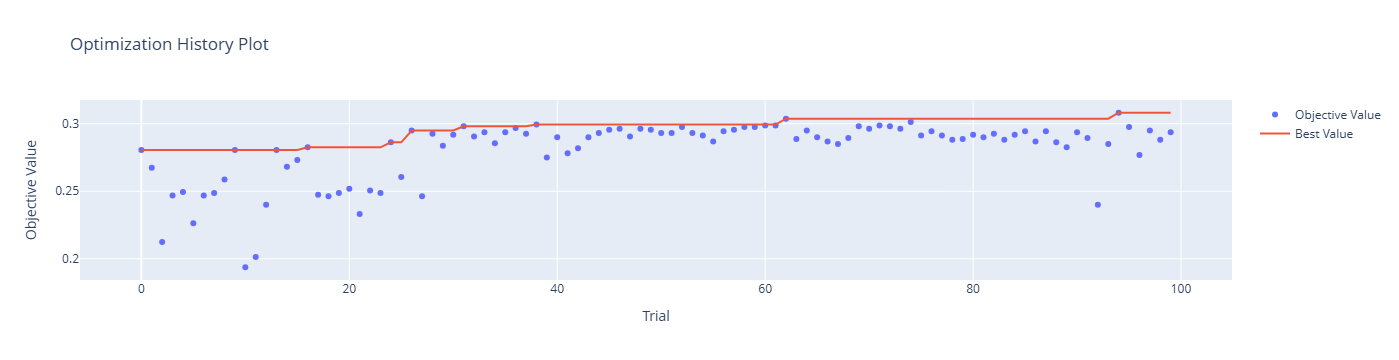

Best trial: 0.308125
Best params: {'max_depth': 3, 'learning_rate': 0.06356667206850741, 'n_estimators': 750, 'subsample': 0.6819440507849533, 'colsample_bytree': 0.5846164941275525, 'min_child_weight': 11, 'gamma': 0.6599518894060192, 'alpha': 9.206107192743795, 'lambda': 1.3287141126284854}
Train Accuracy: 0.7909738717339667
Test Accuracy: 0.3165
Prompt 1 Train Accuracy: 0.79
Prompt 1 Test Accuracy: 0.37
Prompt 2 Train Accuracy: 0.75875
Prompt 2 Test Accuracy: 0.22
Prompt 3 Train Accuracy: 0.82125
Prompt 3 Test Accuracy: 0.325
Prompt 4 Train Accuracy: 0.76375
Prompt 4 Test Accuracy: 0.295
Prompt 5 Train Accuracy: 0.815
Prompt 5 Test Accuracy: 0.335
Prompt 6 Train Accuracy: 0.775
Prompt 6 Test Accuracy: 0.34
Prompt 7 Train Accuracy: 0.8060075093867334
Prompt 7 Test Accuracy: 0.365
Prompt 8 Train Accuracy: 0.7875
Prompt 8 Test Accuracy: 0.24
Prompt 9 Train Accuracy: 0.7675
Prompt 9 Test Accuracy: 0.32
Prompt 10 Train Accuracy: 0.825
Prompt 10 Test Accuracy: 0.355


[I 2026-02-14 04:34:36,237] A new study created in memory with name: no-name-bb713e81-6f47-46e3-825a-22e7dd6436e1


Optimizing Layer 1 at Context Level 100
(9999, 1, 512)
(9999, 512)
0    800
1    800
2    800
3    800
4    800
5    800
7    800
8    800
9    800
6    799
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
9    654
5    646
4    645
2    642
8    640
3    638
6    636
7    636
1    634
0    628
Name: count, dtype: int64
0    172
1    166
7    164
6    163
3    162
8    160
2    158
4    155
5    154
9    146
Name: count, dtype: int64
Train Data Shape:  (7999, 512)
Test Data Shape:  (2000, 512)
Optimizer Train Data Shape:  (6399, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 04:34:54,192] Trial 0 finished with value: 0.194375 and parameters: {'max_depth': 2, 'learning_rate': 0.05422393750965695, 'n_estimators': 187, 'subsample': 0.6749579497482919, 'colsample_bytree': 0.5339168798254461, 'min_child_weight': 6, 'gamma': 8.103678615781636, 'alpha': 8.177963283555025, 'lambda': 5.088789431163885}. Best is trial 0 with value: 0.194375.
[I 2026-02-14 04:35:12,321] Trial 12 finished with value: 0.23875 and parameters: {'max_depth': 3, 'learning_rate': 0.04716848301084958, 'n_estimators': 266, 'subsample': 0.7434687822818671, 'colsample_bytree': 0.6073963997553095, 'min_child_weight': 16, 'gamma': 5.401026922667581, 'alpha': 4.4678596790256915, 'lambda': 5.5572279778187355}. Best is trial 12 with value: 0.23875.
[I 2026-02-14 04:35:24,839] Trial 14 finished with value: 0.191875 and parameters: {'max_depth': 3, 'learning_rate': 0.04795338053782862, 'n_estimators': 552, 'subsample': 0.6099974709620544, 'colsample_bytree': 0.5359370927171415, 'min_chil

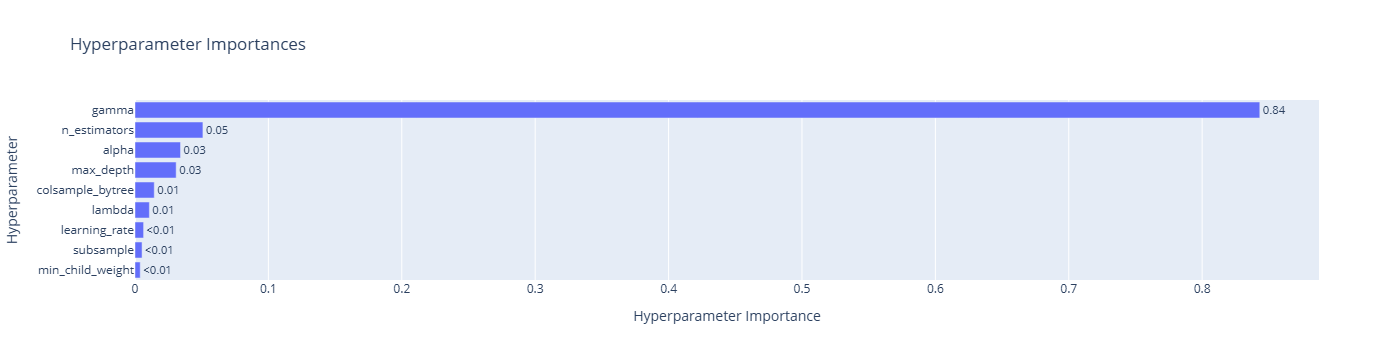

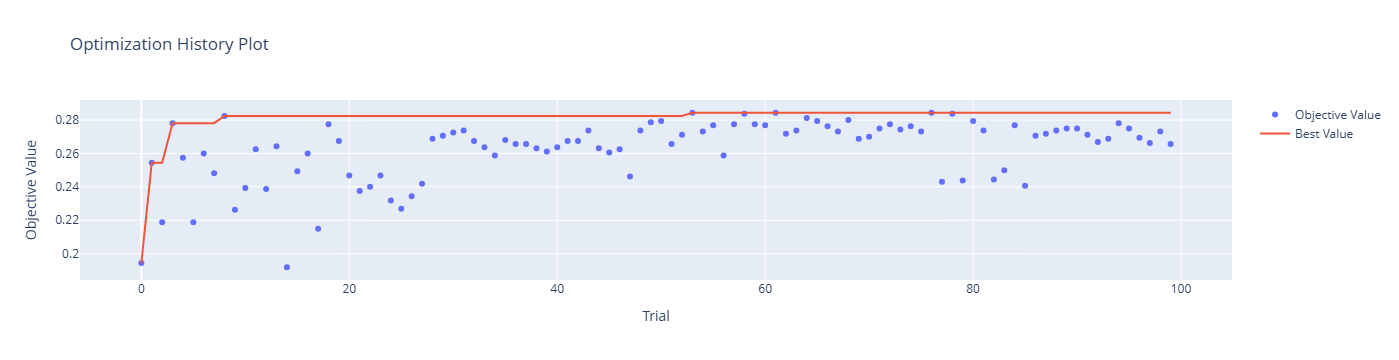

Best trial: 0.284375
Best params: {'max_depth': 3, 'learning_rate': 0.07685319978149648, 'n_estimators': 978, 'subsample': 0.5053478084333295, 'colsample_bytree': 0.681247504817861, 'min_child_weight': 7, 'gamma': 2.2417261786490164, 'alpha': 1.2087043662048351, 'lambda': 4.67225919226139}
Train Accuracy: 0.91836479559945
Test Accuracy: 0.2905
Prompt 1 Train Accuracy: 0.905
Prompt 1 Test Accuracy: 0.33
Prompt 2 Train Accuracy: 0.89375
Prompt 2 Test Accuracy: 0.24
Prompt 3 Train Accuracy: 0.92125
Prompt 3 Test Accuracy: 0.335
Prompt 4 Train Accuracy: 0.9175
Prompt 4 Test Accuracy: 0.285
Prompt 5 Train Accuracy: 0.935
Prompt 5 Test Accuracy: 0.275
Prompt 6 Train Accuracy: 0.925
Prompt 6 Test Accuracy: 0.285
Prompt 7 Train Accuracy: 0.9173967459324155
Prompt 7 Test Accuracy: 0.23
Prompt 8 Train Accuracy: 0.91875
Prompt 8 Test Accuracy: 0.285
Prompt 9 Train Accuracy: 0.925
Prompt 9 Test Accuracy: 0.295
Prompt 10 Train Accuracy: 0.925
Prompt 10 Test Accuracy: 0.345


[I 2026-02-14 04:51:11,391] A new study created in memory with name: no-name-a38e60ba-88c4-479b-9fb1-8a675d16ff9f


Optimizing Layer 1 at Context Level 125
(9999, 1, 512)
(9999, 512)
0    800
1    800
2    800
3    800
4    800
5    800
7    800
8    800
9    800
6    799
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
9    654
5    646
4    645
2    642
8    640
3    638
6    636
7    636
1    634
0    628
Name: count, dtype: int64
0    172
1    166
7    164
6    163
3    162
8    160
2    158
4    155
5    154
9    146
Name: count, dtype: int64
Train Data Shape:  (7999, 512)
Test Data Shape:  (2000, 512)
Optimizer Train Data Shape:  (6399, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 04:51:17,858] Trial 7 finished with value: 0.200625 and parameters: {'max_depth': 3, 'learning_rate': 0.04919489492281734, 'n_estimators': 32, 'subsample': 0.7211431529981022, 'colsample_bytree': 0.5618568591891057, 'min_child_weight': 19, 'gamma': 3.550881492042275, 'alpha': 7.0438641038283, 'lambda': 6.770110827876351}. Best is trial 7 with value: 0.200625.
[I 2026-02-14 04:51:27,742] Trial 8 finished with value: 0.185 and parameters: {'max_depth': 2, 'learning_rate': 0.02553154754977962, 'n_estimators': 149, 'subsample': 0.7305477369252096, 'colsample_bytree': 0.5193290607579564, 'min_child_weight': 8, 'gamma': 9.81546563655686, 'alpha': 0.3338397344373123, 'lambda': 2.9512318106102557}. Best is trial 7 with value: 0.200625.
[I 2026-02-14 04:51:44,024] Trial 14 finished with value: 0.200625 and parameters: {'max_depth': 1, 'learning_rate': 0.028364931821405613, 'n_estimators': 385, 'subsample': 0.5197051719908097, 'colsample_bytree': 0.5649036980791603, 'min_child_weig

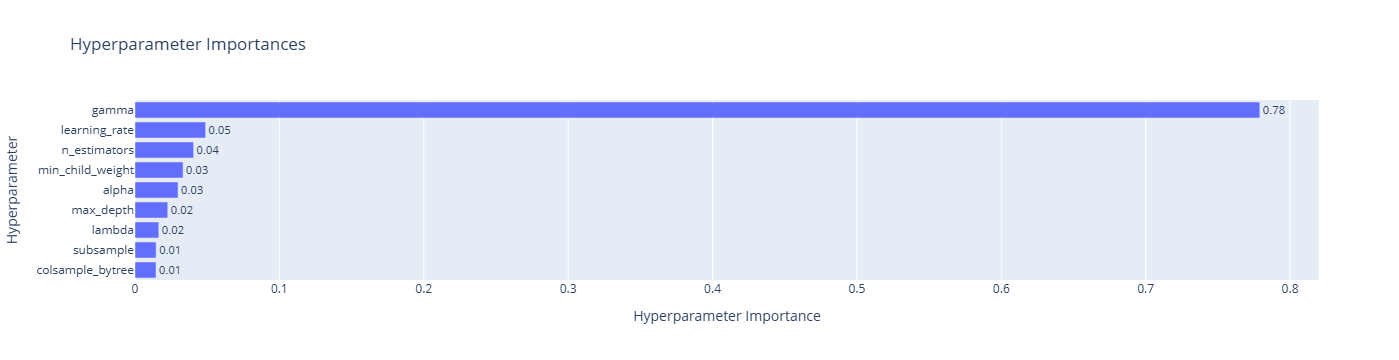

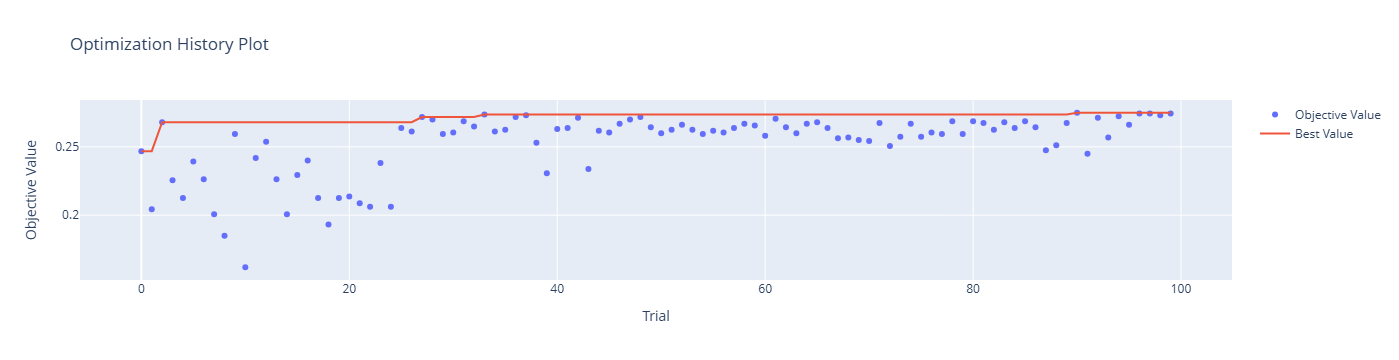

Best trial: 0.275
Best params: {'max_depth': 2, 'learning_rate': 0.08398842048070461, 'n_estimators': 939, 'subsample': 0.5910265639155261, 'colsample_bytree': 0.6139389493787087, 'min_child_weight': 12, 'gamma': 0.5473862000309185, 'alpha': 0.8425527226413353, 'lambda': 4.572105212642694}
Train Accuracy: 0.7864733091636454
Test Accuracy: 0.2755
Prompt 1 Train Accuracy: 0.76625
Prompt 1 Test Accuracy: 0.28
Prompt 2 Train Accuracy: 0.78625
Prompt 2 Test Accuracy: 0.275
Prompt 3 Train Accuracy: 0.8025
Prompt 3 Test Accuracy: 0.3
Prompt 4 Train Accuracy: 0.76125
Prompt 4 Test Accuracy: 0.22
Prompt 5 Train Accuracy: 0.81375
Prompt 5 Test Accuracy: 0.265
Prompt 6 Train Accuracy: 0.78375
Prompt 6 Test Accuracy: 0.305
Prompt 7 Train Accuracy: 0.7872340425531915
Prompt 7 Test Accuracy: 0.365
Prompt 8 Train Accuracy: 0.7825
Prompt 8 Test Accuracy: 0.215
Prompt 9 Train Accuracy: 0.7575
Prompt 9 Test Accuracy: 0.225
Prompt 10 Train Accuracy: 0.82375
Prompt 10 Test Accuracy: 0.305
Optimizing Layer

[I 2026-02-14 05:05:32,596] A new study created in memory with name: no-name-093250cc-a7ef-48f5-9250-076a1dd14071


(9984, 512)
1    800
2    800
4    800
8    800
0    799
9    799
5    798
3    797
6    796
7    796
Name: count, dtype: int64
0    200
1    200
2    200
3    200
4    200
5    200
7    200
8    200
9    200
6    199
Name: count, dtype: int64
6    656
7    651
3    641
9    641
4    641
2    638
5    637
1    633
0    627
8    623
Name: count, dtype: int64
8    177
0    172
1    167
2    162
5    161
4    159
9    158
3    156
7    145
6    140
Name: count, dtype: int64
Train Data Shape:  (7985, 512)
Test Data Shape:  (1999, 512)
Optimizer Train Data Shape:  (6388, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 05:06:01,930] Trial 1 finished with value: 0.17908578584846588 and parameters: {'max_depth': 4, 'learning_rate': 0.023781423198091067, 'n_estimators': 267, 'subsample': 0.5094795293881711, 'colsample_bytree': 0.5797184686425604, 'min_child_weight': 18, 'gamma': 9.351431250791503, 'alpha': 2.863644039279131, 'lambda': 7.570012976565671}. Best is trial 1 with value: 0.17908578584846588.
[I 2026-02-14 05:06:14,353] Trial 7 finished with value: 0.19536631183469005 and parameters: {'max_depth': 2, 'learning_rate': 0.09550129540491979, 'n_estimators': 471, 'subsample': 0.7232933371802925, 'colsample_bytree': 0.5198561988746715, 'min_child_weight': 9, 'gamma': 6.06067658506658, 'alpha': 6.838871731477033, 'lambda': 3.64726152484378}. Best is trial 7 with value: 0.19536631183469005.
[I 2026-02-14 05:06:16,827] Trial 0 finished with value: 0.17908578584846588 and parameters: {'max_depth': 1, 'learning_rate': 0.09936179844521037, 'n_estimators': 546, 'subsample': 0.5308334199586043

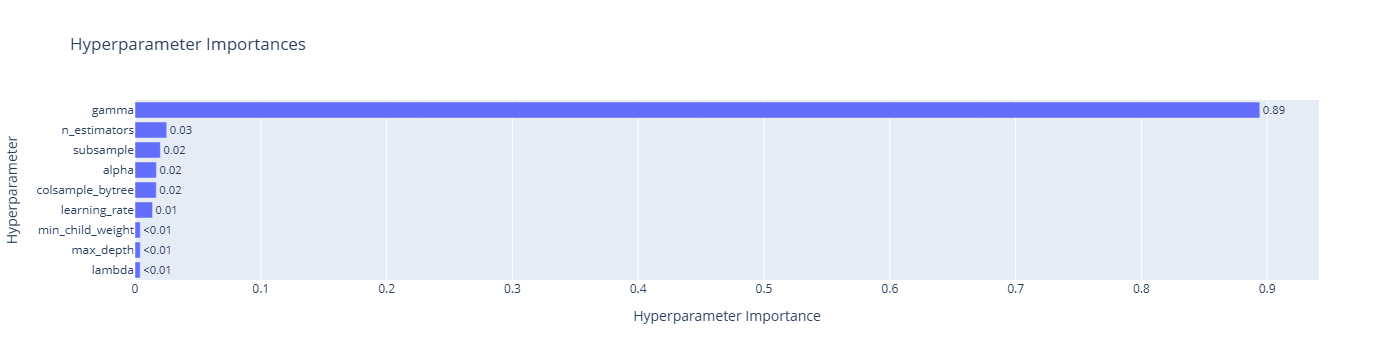

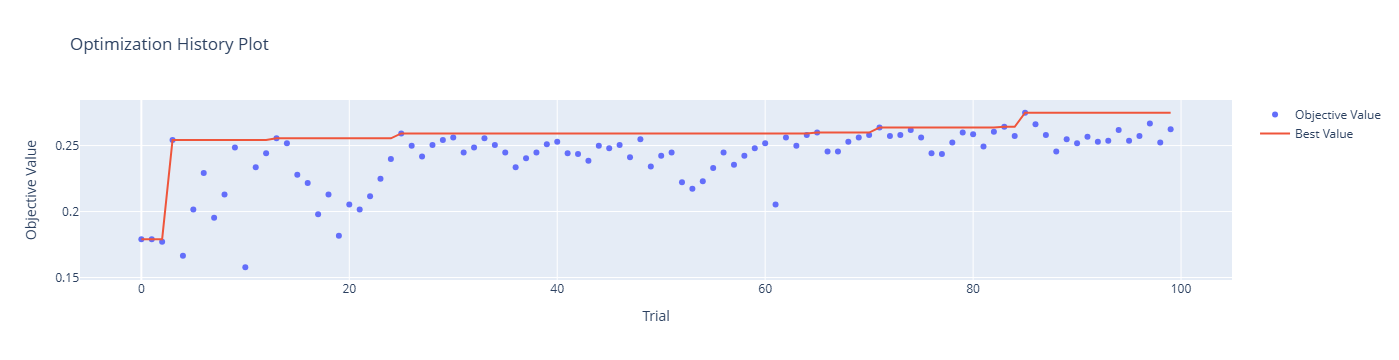

Best trial: 0.2748904195366312
Best params: {'max_depth': 5, 'learning_rate': 0.0989170858761689, 'n_estimators': 917, 'subsample': 0.6188081399814396, 'colsample_bytree': 0.7032567440725775, 'min_child_weight': 19, 'gamma': 0.20500050674941345, 'alpha': 0.9240856196635054, 'lambda': 7.734503619082462}
Train Accuracy: 0.9998747651847214
Test Accuracy: 0.263631815907954
Prompt 1 Train Accuracy: 1.0
Prompt 1 Test Accuracy: 0.26
Prompt 2 Train Accuracy: 1.0
Prompt 2 Test Accuracy: 0.23
Prompt 3 Train Accuracy: 1.0
Prompt 3 Test Accuracy: 0.29
Prompt 4 Train Accuracy: 1.0
Prompt 4 Test Accuracy: 0.23
Prompt 5 Train Accuracy: 1.0
Prompt 5 Test Accuracy: 0.29
Prompt 6 Train Accuracy: 1.0
Prompt 6 Test Accuracy: 0.27
Prompt 7 Train Accuracy: 1.0
Prompt 7 Test Accuracy: 0.2562814070351759
Prompt 8 Train Accuracy: 1.0
Prompt 8 Test Accuracy: 0.245
Prompt 9 Train Accuracy: 0.99875
Prompt 9 Test Accuracy: 0.245
Prompt 10 Train Accuracy: 1.0
Prompt 10 Test Accuracy: 0.32


[I 2026-02-14 05:27:53,960] A new study created in memory with name: no-name-8b649ca8-85ed-4031-9f98-86a748abad64


Optimizing Layer 1 at Context Level 175
(9835, 1, 512)
(9835, 512)
9    796
2    794
8    794
4    792
0    790
6    782
5    780
1    779
7    779
3    777
Name: count, dtype: int64
9    200
2    199
4    199
8    199
0    198
5    196
6    196
1    195
3    195
7    195
Name: count, dtype: int64
9    645
6    641
4    637
8    635
2    635
7    625
3    622
5    622
0    617
1    611
Name: count, dtype: int64
0    173
1    168
8    159
2    159
5    158
3    155
4    155
7    154
9    151
6    141
Name: count, dtype: int64
Train Data Shape:  (7863, 512)
Test Data Shape:  (1972, 512)
Optimizer Train Data Shape:  (6290, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 05:27:59,793] Trial 5 finished with value: 0.19389701207883026 and parameters: {'max_depth': 1, 'learning_rate': 0.060397142246848744, 'n_estimators': 56, 'subsample': 0.6748815759923621, 'colsample_bytree': 0.7261709367465066, 'min_child_weight': 16, 'gamma': 4.851890598239056, 'alpha': 1.2234066255324616, 'lambda': 4.630706401575598}. Best is trial 5 with value: 0.19389701207883026.
[I 2026-02-14 05:27:59,847] Trial 3 finished with value: 0.2231404958677686 and parameters: {'max_depth': 2, 'learning_rate': 0.09834806954070745, 'n_estimators': 46, 'subsample': 0.7035770997019508, 'colsample_bytree': 0.6849893528308533, 'min_child_weight': 5, 'gamma': 3.811513795752738, 'alpha': 0.8763961459763381, 'lambda': 2.356855856074941}. Best is trial 3 with value: 0.2231404958677686.
[I 2026-02-14 05:28:06,592] Trial 2 finished with value: 0.19643992371265098 and parameters: {'max_depth': 5, 'learning_rate': 0.031943969567440195, 'n_estimators': 96, 'subsample': 0.5518100508232133

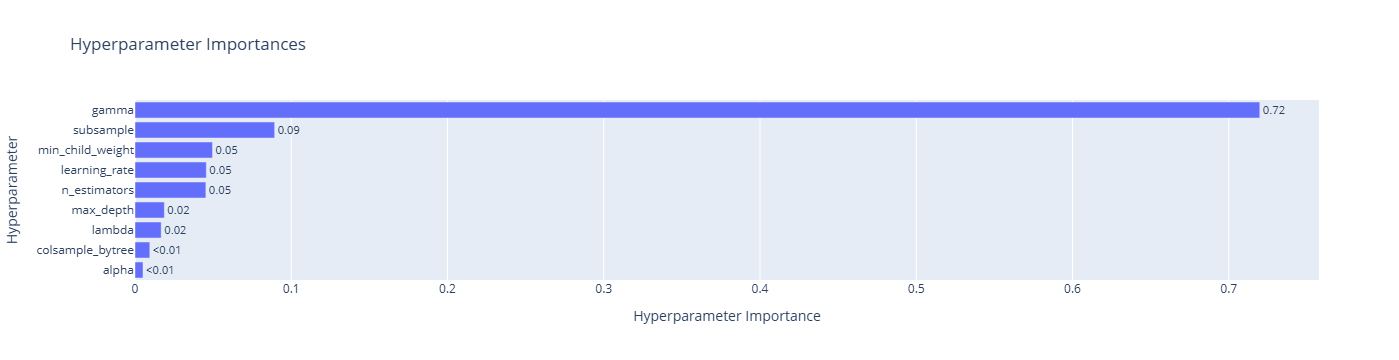

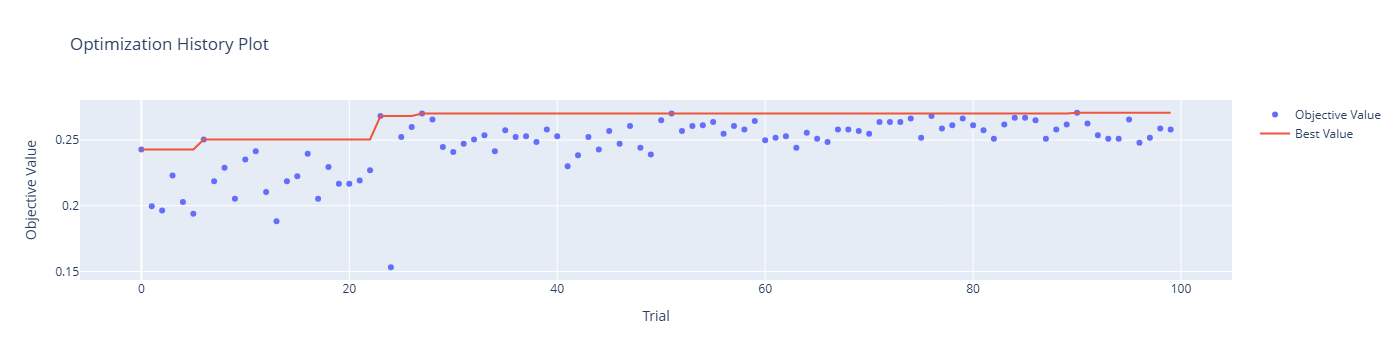

Best trial: 0.2708200890019072
Best params: {'max_depth': 6, 'learning_rate': 0.055464459863135994, 'n_estimators': 878, 'subsample': 0.595054221311231, 'colsample_bytree': 0.5614232885248475, 'min_child_weight': 18, 'gamma': 0.789089427755436, 'alpha': 3.4392044908007176, 'lambda': 8.489562273975125}
Train Accuracy: 0.9835940480732545
Test Accuracy: 0.2672413793103448
Prompt 1 Train Accuracy: 0.9772151898734177
Prompt 1 Test Accuracy: 0.2727272727272727
Prompt 2 Train Accuracy: 0.9845956354300385
Prompt 2 Test Accuracy: 0.24615384615384617
Prompt 3 Train Accuracy: 0.9861460957178841
Prompt 3 Test Accuracy: 0.2613065326633166
Prompt 4 Train Accuracy: 0.9794079794079794
Prompt 4 Test Accuracy: 0.22564102564102564
Prompt 5 Train Accuracy: 0.9873737373737373
Prompt 5 Test Accuracy: 0.3165829145728643
Prompt 6 Train Accuracy: 0.9846153846153847
Prompt 6 Test Accuracy: 0.2755102040816326
Prompt 7 Train Accuracy: 0.9833759590792839
Prompt 7 Test Accuracy: 0.2755102040816326
Prompt 8 Train Ac

[I 2026-02-14 05:43:17,425] A new study created in memory with name: no-name-5e7a7dad-7bd6-4fce-b5a3-8fd2ab876508


Optimizing Layer 1 at Context Level 200
(9361, 1, 512)
(9361, 512)
8    779
2    777
9    776
4    764
0    755
6    732
7    732
5    728
1    724
3    718
Name: count, dtype: int64
2    195
8    195
9    195
4    192
0    189
7    184
6    183
5    182
1    181
3    180
Name: count, dtype: int64
9    632
8    628
4    620
2    605
0    591
6    588
7    584
3    584
1    581
5    575
Name: count, dtype: int64
2    172
0    164
5    153
8    151
7    148
9    144
4    144
6    144
1    143
3    134
Name: count, dtype: int64
Train Data Shape:  (7485, 512)
Test Data Shape:  (1876, 512)
Optimizer Train Data Shape:  (5988, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 05:43:26,442] Trial 12 finished with value: 0.21309285237140949 and parameters: {'max_depth': 3, 'learning_rate': 0.031150565079442152, 'n_estimators': 49, 'subsample': 0.7189012507091842, 'colsample_bytree': 0.659285239359402, 'min_child_weight': 14, 'gamma': 4.585577486193379, 'alpha': 6.028967880027927, 'lambda': 6.681651509284449}. Best is trial 12 with value: 0.21309285237140949.
[I 2026-02-14 05:43:38,911] Trial 15 finished with value: 0.23981295925183702 and parameters: {'max_depth': 4, 'learning_rate': 0.08606187311430408, 'n_estimators': 148, 'subsample': 0.7164203389901628, 'colsample_bytree': 0.6004210363595888, 'min_child_weight': 13, 'gamma': 5.535500257471582, 'alpha': 3.0632178114686703, 'lambda': 3.2041169069892845}. Best is trial 15 with value: 0.23981295925183702.
[I 2026-02-14 05:43:40,957] Trial 3 finished with value: 0.20507682030728122 and parameters: {'max_depth': 3, 'learning_rate': 0.015718209211212624, 'n_estimators': 150, 'subsample': 0.66738312

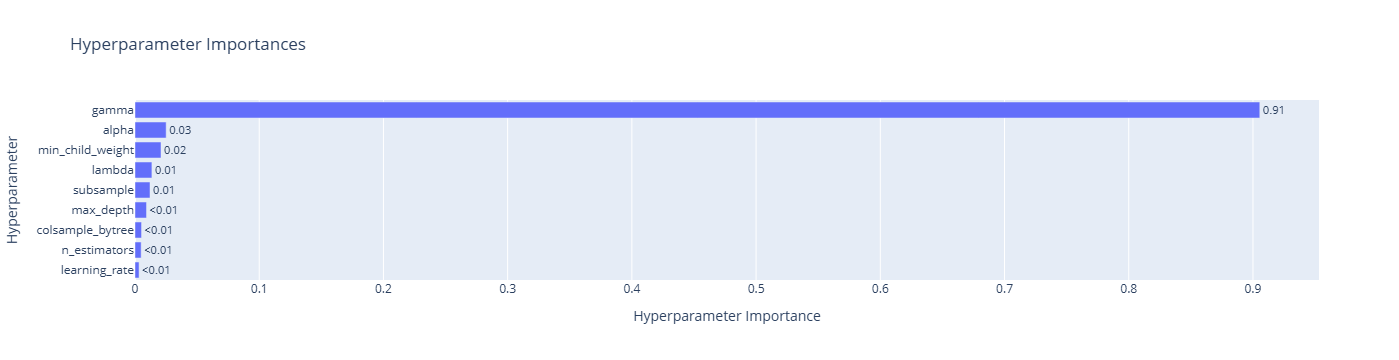

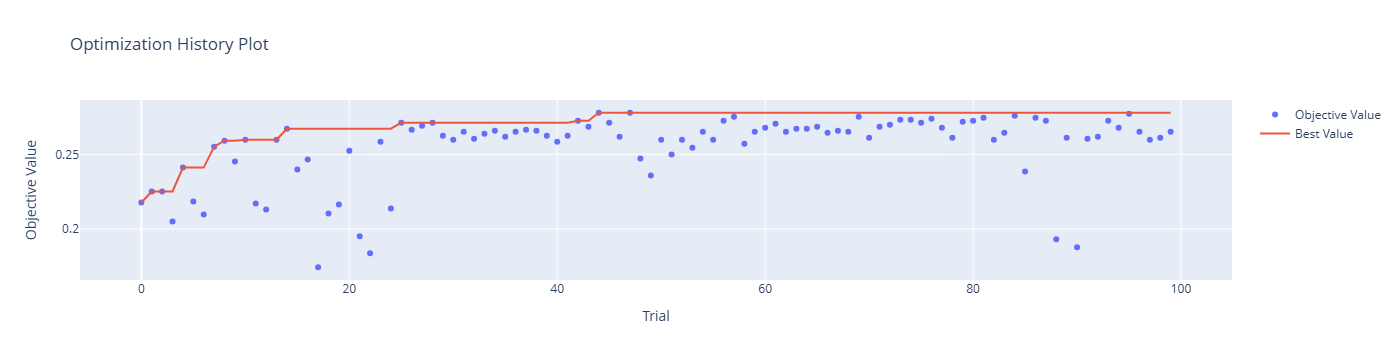

Best trial: 0.27788911155644624
Best params: {'max_depth': 6, 'learning_rate': 0.08016378751472822, 'n_estimators': 799, 'subsample': 0.5787358660299187, 'colsample_bytree': 0.5414759907830275, 'min_child_weight': 8, 'gamma': 0.6390015433219063, 'alpha': 9.293041876546893, 'lambda': 2.071406093293942}
Train Accuracy: 0.9457581830327322
Test Accuracy: 0.26066098081023453
Prompt 1 Train Accuracy: 0.9483443708609272
Prompt 1 Test Accuracy: 0.2275132275132275
Prompt 2 Train Accuracy: 0.9295580110497238
Prompt 2 Test Accuracy: 0.2265193370165746
Prompt 3 Train Accuracy: 0.9575289575289575
Prompt 3 Test Accuracy: 0.36923076923076925
Prompt 4 Train Accuracy: 0.9331476323119777
Prompt 4 Test Accuracy: 0.22777777777777777
Prompt 5 Train Accuracy: 0.9489528795811518
Prompt 5 Test Accuracy: 0.296875
Prompt 6 Train Accuracy: 0.9519230769230769
Prompt 6 Test Accuracy: 0.27472527472527475
Prompt 7 Train Accuracy: 0.9494535519125683
Prompt 7 Test Accuracy: 0.22404371584699453
Prompt 8 Train Accuracy:

[I 2026-02-14 06:02:31,598] A new study created in memory with name: no-name-e72a67f4-aaad-412e-9895-46ed62745010


Optimizing Layer 1 at Context Level 225
(8394, 1, 512)
(8394, 512)
9    738
2    720
8    709
4    692
0    675
7    652
1    636
6    635
5    630
3    624
Name: count, dtype: int64
9    185
2    180
8    178
4    174
0    169
7    164
1    160
6    159
5    158
3    156
Name: count, dtype: int64
9    604
8    563
2    562
4    548
7    524
0    522
1    520
3    515
6    509
5    501
Name: count, dtype: int64
2    158
0    153
8    146
4    144
9    134
5    129
7    128
6    126
1    116
3    109
Name: count, dtype: int64
Train Data Shape:  (6711, 512)
Test Data Shape:  (1683, 512)
Optimizer Train Data Shape:  (5368, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:02:41,540] Trial 0 finished with value: 0.1950856291883842 and parameters: {'max_depth': 1, 'learning_rate': 0.013370217850172417, 'n_estimators': 120, 'subsample': 0.5266128411635842, 'colsample_bytree': 0.72178286570691, 'min_child_weight': 11, 'gamma': 5.647753626504363, 'alpha': 0.7083532698706818, 'lambda': 8.271675296561748}. Best is trial 0 with value: 0.1950856291883842.
[I 2026-02-14 06:03:00,588] Trial 15 finished with value: 0.20625465376023827 and parameters: {'max_depth': 5, 'learning_rate': 0.039505988733386156, 'n_estimators': 256, 'subsample': 0.6439843612688233, 'colsample_bytree': 0.6993672304588772, 'min_child_weight': 19, 'gamma': 6.556821017030322, 'alpha': 6.97972760260153, 'lambda': 5.305355874333824}. Best is trial 15 with value: 0.20625465376023827.
[I 2026-02-14 06:03:04,603] Trial 5 finished with value: 0.21667907669396871 and parameters: {'max_depth': 2, 'learning_rate': 0.08505758943650457, 'n_estimators': 390, 'subsample': 0.73710441970638

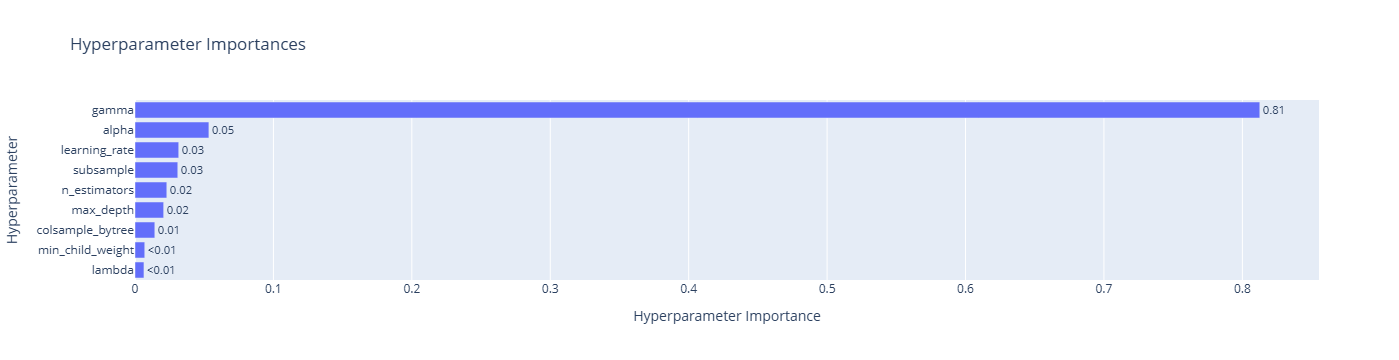

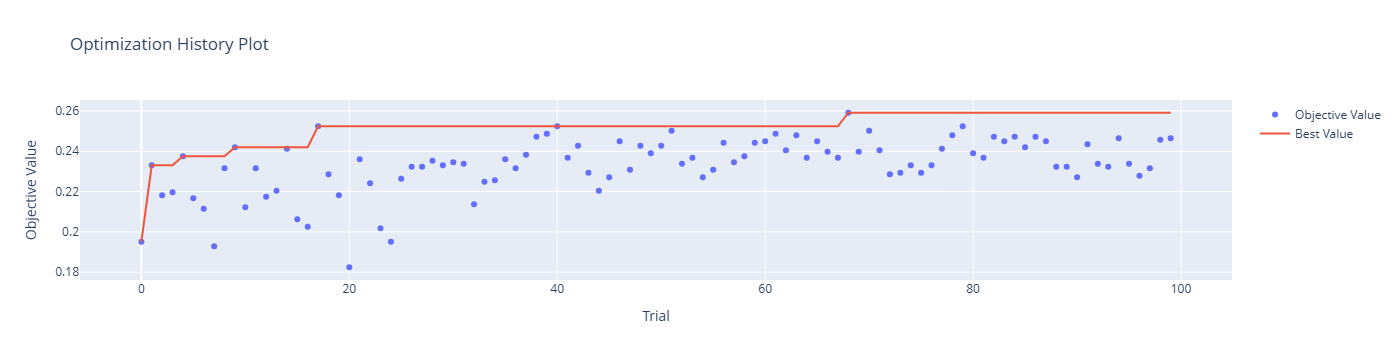

Best trial: 0.25912137006701413
Best params: {'max_depth': 7, 'learning_rate': 0.0943200750884684, 'n_estimators': 373, 'subsample': 0.6281982522743641, 'colsample_bytree': 0.7108550424229861, 'min_child_weight': 20, 'gamma': 0.5494372531433326, 'alpha': 4.369133789752075, 'lambda': 6.0111019625828925}
Train Accuracy: 0.9752644911339592
Test Accuracy: 0.25133689839572193
Prompt 1 Train Accuracy: 0.9674074074074074
Prompt 1 Test Accuracy: 0.23076923076923078
Prompt 2 Train Accuracy: 0.9748427672955975
Prompt 2 Test Accuracy: 0.19375
Prompt 3 Train Accuracy: 0.9805555555555555
Prompt 3 Test Accuracy: 0.3111111111111111
Prompt 4 Train Accuracy: 0.9647435897435898
Prompt 4 Test Accuracy: 0.21794871794871795
Prompt 5 Train Accuracy: 0.9826589595375722
Prompt 5 Test Accuracy: 0.3275862068965517
Prompt 6 Train Accuracy: 0.9841269841269841
Prompt 6 Test Accuracy: 0.22151898734177214
Prompt 7 Train Accuracy: 0.9700787401574803
Prompt 7 Test Accuracy: 0.22012578616352202
Prompt 8 Train Accuracy:

[I 2026-02-14 06:11:45,284] A new study created in memory with name: no-name-869af707-cecd-4a92-9f6c-c645b43a4122


Optimizing Layer 1 at Context Level 250
(6898, 1, 512)
(6898, 512)
9    648
8    624
2    621
4    581
0    548
7    522
6    501
1    495
3    492
5    483
Name: count, dtype: int64
9    162
2    156
8    156
4    146
0    138
7    131
6    126
1    124
3    123
5    121
Name: count, dtype: int64
9    533
8    487
2    478
4    454
7    424
0    420
6    417
3    408
1    398
5    393
Name: count, dtype: int64
2    143
8    137
0    128
4    127
9    115
7     98
1     97
5     90
6     84
3     84
Name: count, dtype: int64
Train Data Shape:  (5515, 512)
Test Data Shape:  (1383, 512)
Optimizer Train Data Shape:  (4412, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:11:50,779] Trial 14 finished with value: 0.1840435176790571 and parameters: {'max_depth': 2, 'learning_rate': 0.06818765779626364, 'n_estimators': 50, 'subsample': 0.5239703971837466, 'colsample_bytree': 0.5008176695526891, 'min_child_weight': 19, 'gamma': 3.3035664884926943, 'alpha': 9.308954095035608, 'lambda': 2.6776414171005785}. Best is trial 14 with value: 0.1840435176790571.
[I 2026-02-14 06:11:58,698] Trial 6 finished with value: 0.1931097008159565 and parameters: {'max_depth': 2, 'learning_rate': 0.06284003445039184, 'n_estimators': 118, 'subsample': 0.6871004230948015, 'colsample_bytree': 0.7262499439976616, 'min_child_weight': 19, 'gamma': 6.5837013844511825, 'alpha': 1.202475806267106, 'lambda': 6.063662891775187}. Best is trial 6 with value: 0.1931097008159565.
[I 2026-02-14 06:12:08,731] Trial 16 finished with value: 0.18223028105167724 and parameters: {'max_depth': 4, 'learning_rate': 0.07761833475546594, 'n_estimators': 195, 'subsample': 0.6401258752177

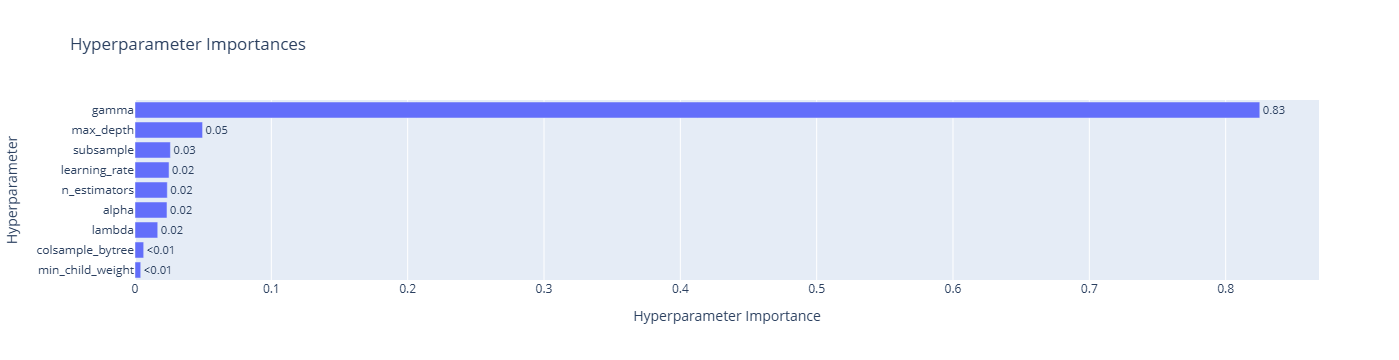

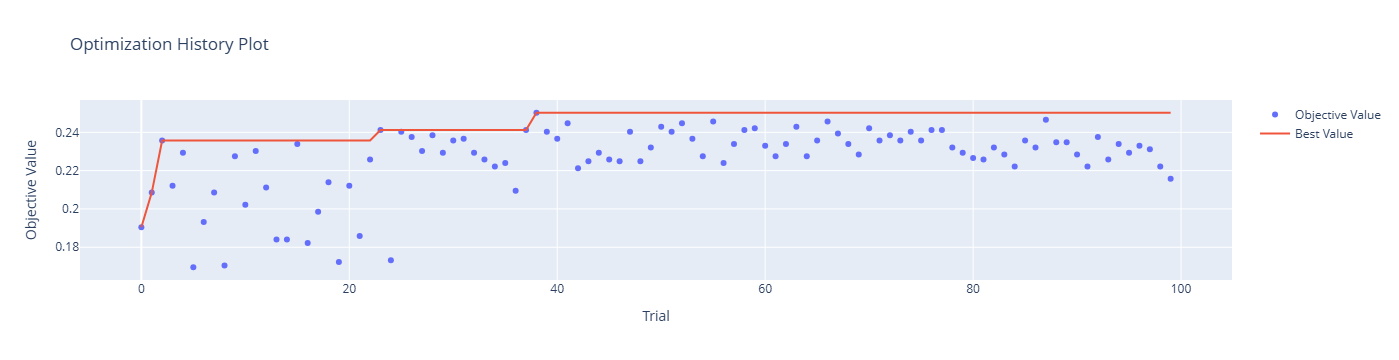

Best trial: 0.25022665457842247
Best params: {'max_depth': 7, 'learning_rate': 0.04452089841971611, 'n_estimators': 745, 'subsample': 0.5912953551878259, 'colsample_bytree': 0.6857836621851027, 'min_child_weight': 8, 'gamma': 0.4766985066320026, 'alpha': 5.743684674741848, 'lambda': 3.9497025685534375}
Train Accuracy: 0.9842248413417951
Test Accuracy: 0.2393347794649313
Prompt 1 Train Accuracy: 0.9872262773722628
Prompt 1 Test Accuracy: 0.21014492753623187
Prompt 2 Train Accuracy: 0.9838383838383838
Prompt 2 Test Accuracy: 0.13709677419354838
Prompt 3 Train Accuracy: 0.9887278582930756
Prompt 3 Test Accuracy: 0.2948717948717949
Prompt 4 Train Accuracy: 0.9715447154471545
Prompt 4 Test Accuracy: 0.24390243902439024
Prompt 5 Train Accuracy: 0.9896729776247849
Prompt 5 Test Accuracy: 0.2465753424657534
Prompt 6 Train Accuracy: 0.9772256728778468
Prompt 6 Test Accuracy: 0.2231404958677686
Prompt 7 Train Accuracy: 0.9820359281437125
Prompt 7 Test Accuracy: 0.21428571428571427
Prompt 8 Train

[I 2026-02-14 06:30:07,353] A new study created in memory with name: no-name-4341d4a4-184f-4cfe-a301-5ca0fc84e166


Optimizing Layer 1 at Context Level 275
(5137, 1, 512)
(5137, 512)
9    508
8    504
2    500
4    452
0    408
7    376
6    347
1    344
5    336
3    328
Name: count, dtype: int64
9    128
8    127
2    126
4    114
0    103
7     95
1     87
6     87
5     85
3     82
Name: count, dtype: int64
9    414
8    406
2    393
4    357
0    307
7    307
1    282
5    273
6    272
3    271
Name: count, dtype: int64
2    107
0    101
8     98
4     95
9     94
6     75
7     69
5     63
1     62
3     57
Name: count, dtype: int64
Train Data Shape:  (4103, 512)
Test Data Shape:  (1034, 512)
Optimizer Train Data Shape:  (3282, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:30:14,577] Trial 13 finished with value: 0.13520097442143728 and parameters: {'max_depth': 2, 'learning_rate': 0.020093419709834005, 'n_estimators': 92, 'subsample': 0.6028681862255723, 'colsample_bytree': 0.6630861773687158, 'min_child_weight': 18, 'gamma': 8.223301776960064, 'alpha': 9.765737623534159, 'lambda': 3.4262118988651906}. Best is trial 13 with value: 0.13520097442143728.
[I 2026-02-14 06:30:21,971] Trial 15 finished with value: 0.20341047503045068 and parameters: {'max_depth': 3, 'learning_rate': 0.06577804216205983, 'n_estimators': 83, 'subsample': 0.7336691796012147, 'colsample_bytree': 0.5425421035912431, 'min_child_weight': 12, 'gamma': 0.7021002944438703, 'alpha': 6.328719665807824, 'lambda': 8.91232950376589}. Best is trial 15 with value: 0.20341047503045068.
[I 2026-02-14 06:30:26,937] Trial 5 finished with value: 0.18757612667478685 and parameters: {'max_depth': 1, 'learning_rate': 0.08439422239949708, 'n_estimators': 267, 'subsample': 0.5441159975

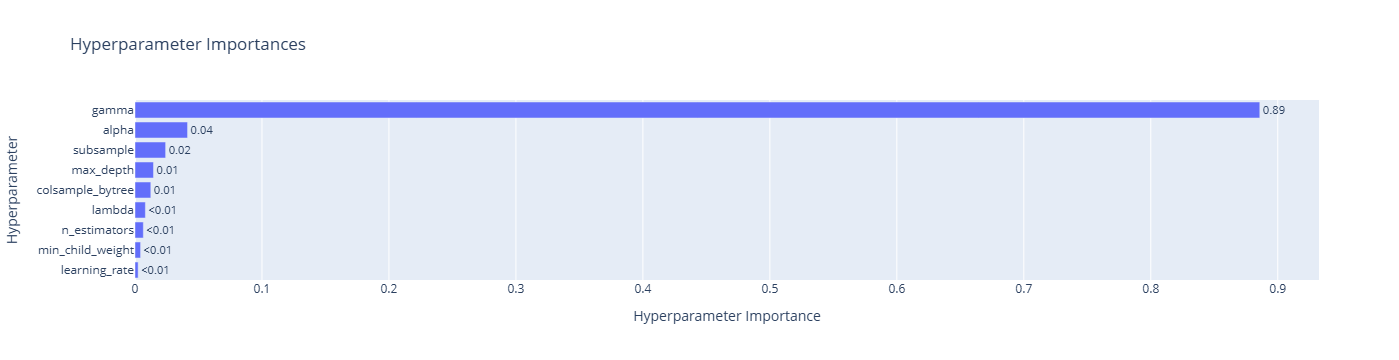

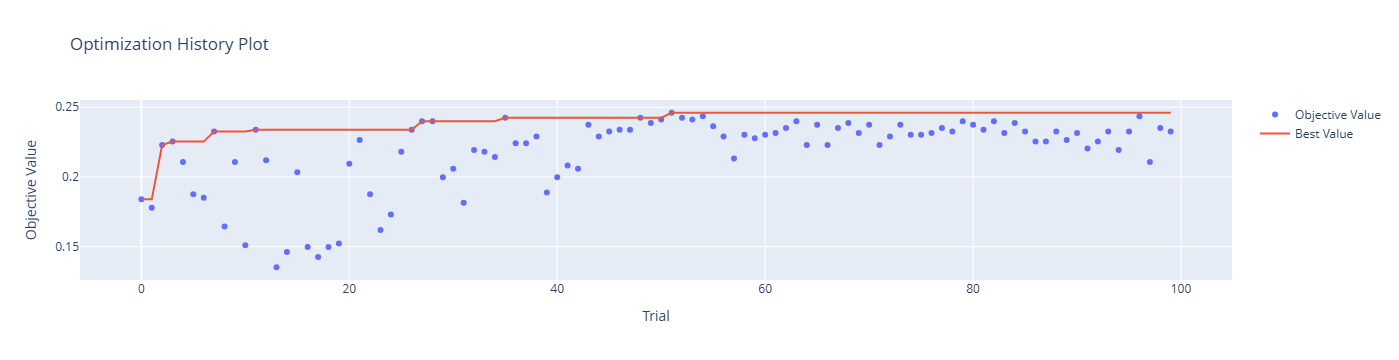

Best trial: 0.24604141291108406
Best params: {'max_depth': 6, 'learning_rate': 0.03890182437186421, 'n_estimators': 576, 'subsample': 0.6763089145237074, 'colsample_bytree': 0.5214412625517453, 'min_child_weight': 10, 'gamma': 1.371890255750537, 'alpha': 4.674459457303556, 'lambda': 1.61328033095893}
Train Accuracy: 0.9015354618571777
Test Accuracy: 0.23597678916827852
Prompt 1 Train Accuracy: 0.9117647058823529
Prompt 1 Test Accuracy: 0.2621359223300971
Prompt 2 Train Accuracy: 0.8517441860465116
Prompt 2 Test Accuracy: 0.08045977011494253
Prompt 3 Train Accuracy: 0.956
Prompt 3 Test Accuracy: 0.3253968253968254
Prompt 4 Train Accuracy: 0.8262195121951219
Prompt 4 Test Accuracy: 0.14634146341463414
Prompt 5 Train Accuracy: 0.9247787610619469
Prompt 5 Test Accuracy: 0.32456140350877194
Prompt 6 Train Accuracy: 0.875
Prompt 6 Test Accuracy: 0.21176470588235294
Prompt 7 Train Accuracy: 0.8760806916426513
Prompt 7 Test Accuracy: 0.26436781609195403
Prompt 8 Train Accuracy: 0.8776595744680

[I 2026-02-14 06:44:01,558] A new study created in memory with name: no-name-ae037dfb-b584-46db-a2af-b65a63bcbc2f


Optimizing Layer 1 at Context Level 300
(3342, 1, 512)
(3342, 512)
9    370
8    365
2    343
4    292
0    256
7    230
6    217
1    211
5    206
3    180
Name: count, dtype: int64
9    93
8    92
2    86
4    73
0    64
7    58
6    55
1    53
5    52
3    46
Name: count, dtype: int64
9    300
8    288
2    276
4    228
0    204
6    183
7    178
5    172
1    165
3    142
Name: count, dtype: int64
8    77
9    70
2    67
4    64
0    52
7    52
1    46
3    38
5    34
6    34
Name: count, dtype: int64
Train Data Shape:  (2670, 512)
Test Data Shape:  (672, 512)
Optimizer Train Data Shape:  (2136, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:44:15,828] Trial 8 finished with value: 0.16292134831460675 and parameters: {'max_depth': 1, 'learning_rate': 0.04997501155514016, 'n_estimators': 213, 'subsample': 0.5928226367868948, 'colsample_bytree': 0.5905353616335609, 'min_child_weight': 14, 'gamma': 3.8892228076371325, 'alpha': 0.3104674380832029, 'lambda': 5.541025347366547}. Best is trial 8 with value: 0.16292134831460675.
[I 2026-02-14 06:44:16,042] Trial 12 finished with value: 0.1797752808988764 and parameters: {'max_depth': 4, 'learning_rate': 0.01226818493813176, 'n_estimators': 64, 'subsample': 0.6442455750465235, 'colsample_bytree': 0.5565358702345142, 'min_child_weight': 13, 'gamma': 0.26424847155208764, 'alpha': 6.425476506620141, 'lambda': 6.552744879569955}. Best is trial 12 with value: 0.1797752808988764.
[I 2026-02-14 06:44:17,878] Trial 15 finished with value: 0.1647940074906367 and parameters: {'max_depth': 4, 'learning_rate': 0.09369237765266808, 'n_estimators': 208, 'subsample': 0.73717868114

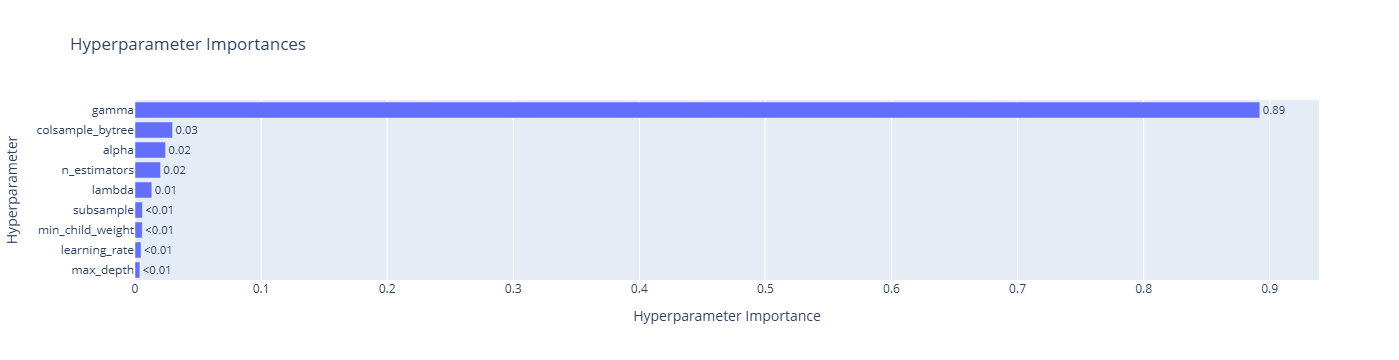

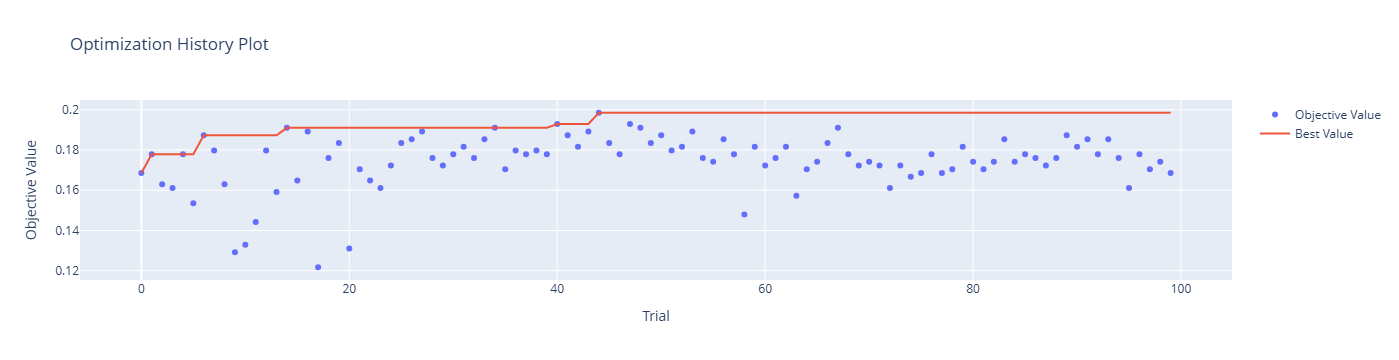

Best trial: 0.19850187265917604
Best params: {'max_depth': 2, 'learning_rate': 0.028084201577165943, 'n_estimators': 970, 'subsample': 0.5849351776631504, 'colsample_bytree': 0.7089321326380547, 'min_child_weight': 7, 'gamma': 2.9695176509449634, 'alpha': 4.2277224674137415, 'lambda': 2.5503361783964236}
Train Accuracy: 0.5853932584269663
Test Accuracy: 0.20833333333333334
Prompt 1 Train Accuracy: 0.52734375
Prompt 1 Test Accuracy: 0.109375
Prompt 2 Train Accuracy: 0.4881516587677725
Prompt 2 Test Accuracy: 0.09433962264150944
Prompt 3 Train Accuracy: 0.8134110787172012
Prompt 3 Test Accuracy: 0.313953488372093
Prompt 4 Train Accuracy: 0.32222222222222224
Prompt 4 Test Accuracy: 0.043478260869565216
Prompt 5 Train Accuracy: 0.6301369863013698
Prompt 5 Test Accuracy: 0.2191780821917808
Prompt 6 Train Accuracy: 0.3786407766990291
Prompt 6 Test Accuracy: 0.1346153846153846
Prompt 7 Train Accuracy: 0.41935483870967744
Prompt 7 Test Accuracy: 0.16363636363636364
Prompt 8 Train Accuracy: 0.3

[I 2026-02-14 06:51:44,994] A new study created in memory with name: no-name-2273de8c-fb03-46c8-bebf-c72764fc8785


Optimizing Layer 1 at Context Level 325
(1890, 1, 512)
(1890, 512)
9    234
8    224
2    202
4    175
0    144
7    114
6    111
1    109
5    100
3     95
Name: count, dtype: int64
9    59
8    57
2    51
4    44
0    36
7    29
1    28
6    28
5    26
3    24
Name: count, dtype: int64
9    191
8    175
2    159
4    137
0    116
6     90
1     90
7     87
5     84
3     77
Name: count, dtype: int64
8    49
2    43
9    43
4    38
0    28
7    27
6    21
1    19
3    18
5    16
Name: count, dtype: int64
Train Data Shape:  (1508, 512)
Test Data Shape:  (382, 512)
Optimizer Train Data Shape:  (1206, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:51:54,649] Trial 9 finished with value: 0.1423841059602649 and parameters: {'max_depth': 6, 'learning_rate': 0.08367404605699227, 'n_estimators': 143, 'subsample': 0.6407753545459338, 'colsample_bytree': 0.7365999841599646, 'min_child_weight': 15, 'gamma': 9.006507049177204, 'alpha': 6.335948138989002, 'lambda': 7.244306797317861}. Best is trial 9 with value: 0.1423841059602649.
[I 2026-02-14 06:52:05,690] Trial 16 finished with value: 0.17218543046357615 and parameters: {'max_depth': 3, 'learning_rate': 0.0523840827408091, 'n_estimators': 147, 'subsample': 0.6535647749358343, 'colsample_bytree': 0.7029082343058176, 'min_child_weight': 15, 'gamma': 7.357206691795188, 'alpha': 0.5429943742795551, 'lambda': 7.668235413573598}. Best is trial 16 with value: 0.17218543046357615.
[I 2026-02-14 06:52:08,408] Trial 6 finished with value: 0.15562913907284767 and parameters: {'max_depth': 7, 'learning_rate': 0.04141653191683537, 'n_estimators': 324, 'subsample': 0.65743377834943

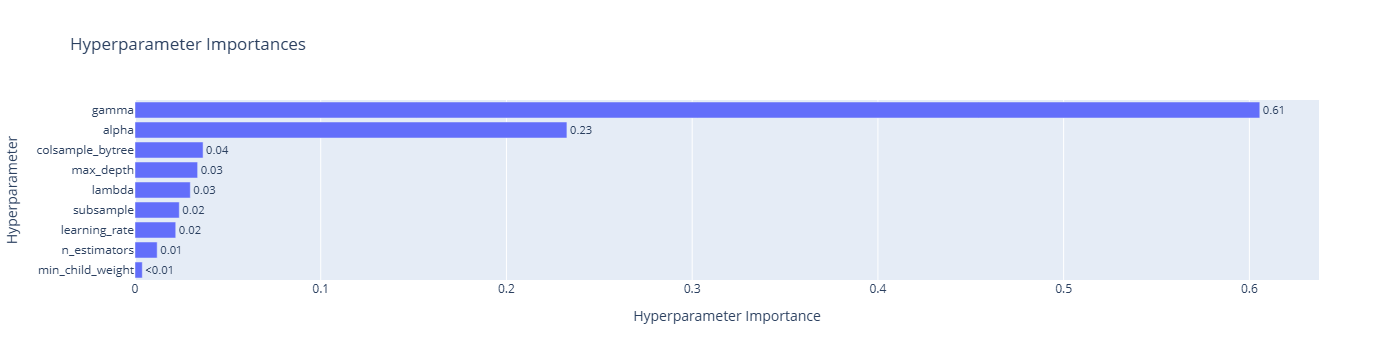

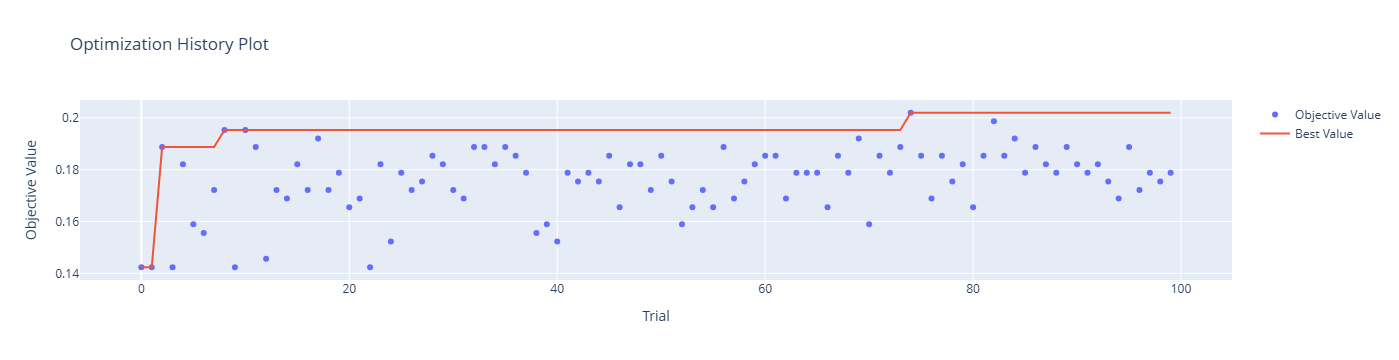

Best trial: 0.20198675496688742
Best params: {'max_depth': 7, 'learning_rate': 0.016832302800841206, 'n_estimators': 180, 'subsample': 0.521465725154046, 'colsample_bytree': 0.7252389008256517, 'min_child_weight': 9, 'gamma': 1.3759386794889625, 'alpha': 5.829406414490998, 'lambda': 8.358571436074971}
Train Accuracy: 0.4807692307692308
Test Accuracy: 0.20680628272251309
Prompt 1 Train Accuracy: 0.3541666666666667
Prompt 1 Test Accuracy: 0.027777777777777776
Prompt 2 Train Accuracy: 0.01834862385321101
Prompt 2 Test Accuracy: 0.0
Prompt 3 Train Accuracy: 0.7277227722772277
Prompt 3 Test Accuracy: 0.2549019607843137
Prompt 4 Train Accuracy: 0.0
Prompt 4 Test Accuracy: 0.0
Prompt 5 Train Accuracy: 0.52
Prompt 5 Test Accuracy: 0.13636363636363635
Prompt 6 Train Accuracy: 0.1
Prompt 6 Test Accuracy: 0.038461538461538464
Prompt 7 Train Accuracy: 0.17117117117117117
Prompt 7 Test Accuracy: 0.03571428571428571
Prompt 8 Train Accuracy: 0.02631578947368421
Prompt 8 Test Accuracy: 0.0
Prompt 9 Tr

[I 2026-02-14 06:56:20,354] A new study created in memory with name: no-name-b945a21e-525e-4021-b853-3ba7e1a83d32


Optimizing Layer 1 at Context Level 350
(985, 1, 512)
(985, 512)
9    141
8    124
2    112
4     96
0     74
7     58
1     51
6     46
3     44
5     40
Name: count, dtype: int64
9    36
8    31
2    28
4    24
0    19
7    15
1    13
6    12
3    11
5    10
Name: count, dtype: int64
9    111
8     97
2     95
4     71
0     58
7     46
3     40
1     39
6     36
5     35
Name: count, dtype: int64
9    30
8    27
4    25
2    17
0    16
7    12
1    12
6    10
5     5
3     4
Name: count, dtype: int64
Train Data Shape:  (786, 512)
Test Data Shape:  (199, 512)
Optimizer Train Data Shape:  (628, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 06:56:24,164] Trial 14 finished with value: 0.189873417721519 and parameters: {'max_depth': 4, 'learning_rate': 0.09139155227081175, 'n_estimators': 61, 'subsample': 0.5961677617607948, 'colsample_bytree': 0.6807772848351576, 'min_child_weight': 18, 'gamma': 3.6384663854826327, 'alpha': 8.776539436169386, 'lambda': 3.414693183216609}. Best is trial 14 with value: 0.189873417721519.
[I 2026-02-14 06:56:29,571] Trial 12 finished with value: 0.189873417721519 and parameters: {'max_depth': 4, 'learning_rate': 0.059287087439101965, 'n_estimators': 142, 'subsample': 0.5943914662040966, 'colsample_bytree': 0.5059914875537614, 'min_child_weight': 13, 'gamma': 4.454650875049167, 'alpha': 3.341826304608845, 'lambda': 8.783402162095676}. Best is trial 14 with value: 0.189873417721519.
[I 2026-02-14 06:56:31,095] Trial 7 finished with value: 0.17088607594936708 and parameters: {'max_depth': 1, 'learning_rate': 0.090750365297426, 'n_estimators': 181, 'subsample': 0.6488755200216882, '

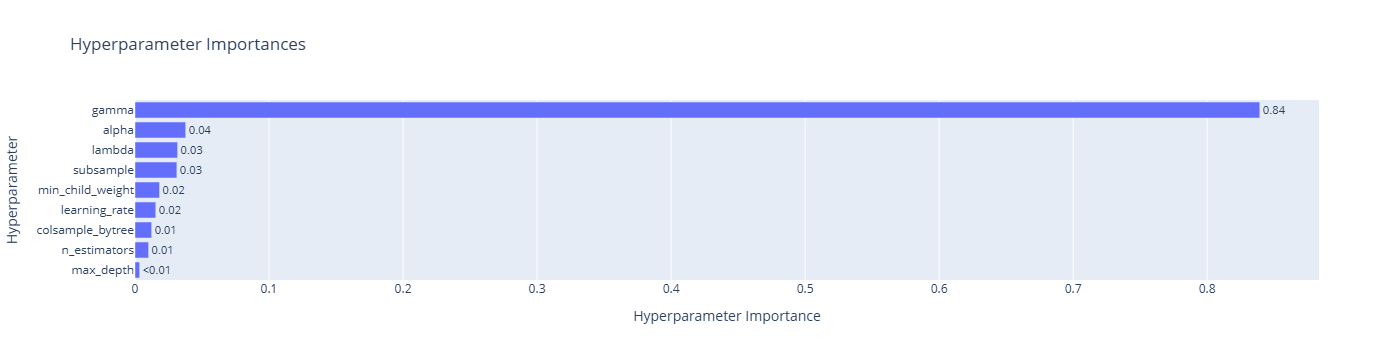

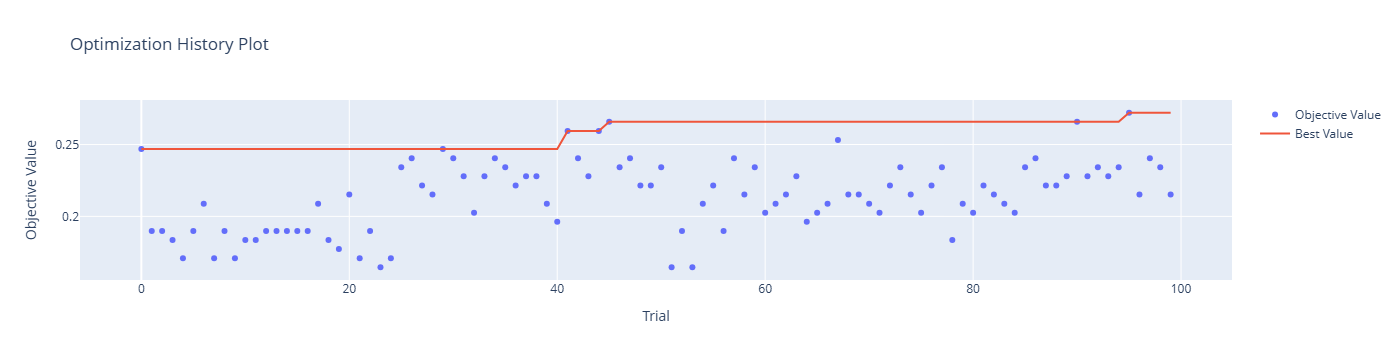

Best trial: 0.2721518987341772
Best params: {'max_depth': 7, 'learning_rate': 0.04074317997933731, 'n_estimators': 794, 'subsample': 0.6895612519030122, 'colsample_bytree': 0.6156697888153061, 'min_child_weight': 7, 'gamma': 0.5705485747901401, 'alpha': 0.6544972143982124, 'lambda': 3.7566499833203224}
Train Accuracy: 1.0
Test Accuracy: 0.22613065326633167
Prompt 1 Train Accuracy: 1.0
Prompt 1 Test Accuracy: 0.10526315789473684
Prompt 2 Train Accuracy: 1.0
Prompt 2 Test Accuracy: 0.07692307692307693
Prompt 3 Train Accuracy: 1.0
Prompt 3 Test Accuracy: 0.25
Prompt 4 Train Accuracy: 1.0
Prompt 4 Test Accuracy: 0.0
Prompt 5 Train Accuracy: 1.0
Prompt 5 Test Accuracy: 0.16666666666666666
Prompt 6 Train Accuracy: 1.0
Prompt 6 Test Accuracy: 0.1
Prompt 7 Train Accuracy: 1.0
Prompt 7 Test Accuracy: 0.08333333333333333
Prompt 8 Train Accuracy: 1.0
Prompt 8 Test Accuracy: 0.13333333333333333
Prompt 9 Train Accuracy: 1.0
Prompt 9 Test Accuracy: 0.45161290322580644
Prompt 10 Train Accuracy: 1.0
P

[I 2026-02-14 07:02:57,822] A new study created in memory with name: no-name-5c23e57c-5f51-4df1-acb9-8c12773f1761


Optimizing Layer 1 at Context Level 375
(474, 1, 512)
(474, 512)
9    72
8    61
2    54
0    37
4    37
7    29
1    24
3    23
5    19
6    18
Name: count, dtype: int64
9    19
8    16
2    14
0    10
4    10
7     8
1     7
3     6
5     5
6     5
Name: count, dtype: int64
9    59
8    53
2    40
4    33
0    28
7    20
3    18
1    17
5    16
6    15
Name: count, dtype: int64
2    14
9    13
0     9
7     9
8     8
1     7
3     5
4     4
5     3
6     3
Name: count, dtype: int64
Train Data Shape:  (374, 512)
Test Data Shape:  (100, 512)
Optimizer Train Data Shape:  (299, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 07:03:02,777] Trial 4 finished with value: 0.14666666666666667 and parameters: {'max_depth': 5, 'learning_rate': 0.030061552814114295, 'n_estimators': 77, 'subsample': 0.5454731171784721, 'colsample_bytree': 0.7309739338638794, 'min_child_weight': 19, 'gamma': 0.16240887095552936, 'alpha': 0.21699130886200013, 'lambda': 1.108603284001347}. Best is trial 4 with value: 0.14666666666666667.
[I 2026-02-14 07:03:03,191] Trial 6 finished with value: 0.12 and parameters: {'max_depth': 4, 'learning_rate': 0.06790670909431452, 'n_estimators': 78, 'subsample': 0.6163288077554894, 'colsample_bytree': 0.5154768238391281, 'min_child_weight': 16, 'gamma': 0.07231979468657168, 'alpha': 1.128769991066566, 'lambda': 6.340767294806693}. Best is trial 4 with value: 0.14666666666666667.
[I 2026-02-14 07:03:07,758] Trial 11 finished with value: 0.17333333333333334 and parameters: {'max_depth': 2, 'learning_rate': 0.017759509682012876, 'n_estimators': 171, 'subsample': 0.6263970057144163, 'col

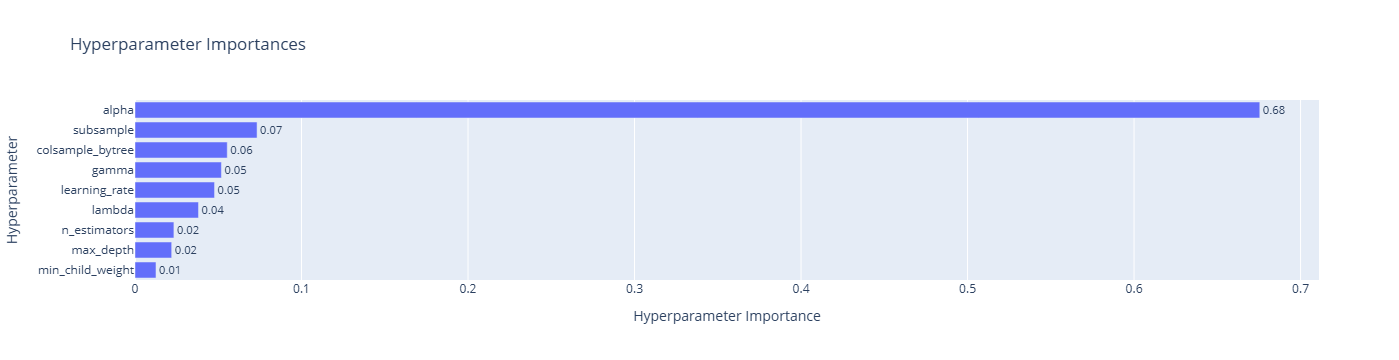

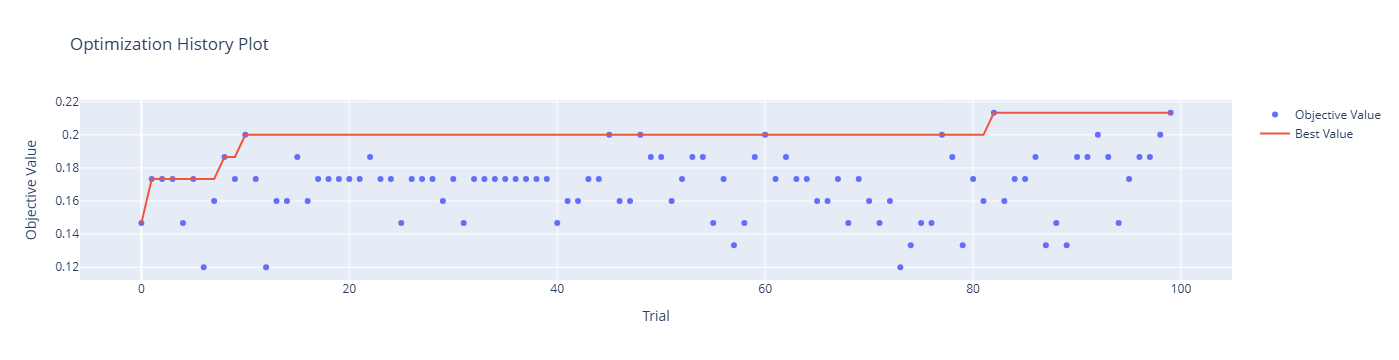

Best trial: 0.21333333333333335
Best params: {'max_depth': 2, 'learning_rate': 0.05573486461341347, 'n_estimators': 54, 'subsample': 0.6058057455012871, 'colsample_bytree': 0.6183006343073139, 'min_child_weight': 9, 'gamma': 0.45308510738251906, 'alpha': 9.070539583949945, 'lambda': 1.3995734113526241}
Train Accuracy: 0.3582887700534759
Test Accuracy: 0.22
Prompt 1 Train Accuracy: 0.0
Prompt 1 Test Accuracy: 0.0
Prompt 2 Train Accuracy: 0.0
Prompt 2 Test Accuracy: 0.0
Prompt 3 Train Accuracy: 0.3333333333333333
Prompt 3 Test Accuracy: 0.07142857142857142
Prompt 4 Train Accuracy: 0.0
Prompt 4 Test Accuracy: 0.0
Prompt 5 Train Accuracy: 0.0
Prompt 5 Test Accuracy: 0.0
Prompt 6 Train Accuracy: 0.0
Prompt 6 Test Accuracy: 0.0
Prompt 7 Train Accuracy: 0.0
Prompt 7 Test Accuracy: 0.0
Prompt 8 Train Accuracy: 0.0
Prompt 8 Test Accuracy: 0.0
Prompt 9 Train Accuracy: 0.7213114754098361
Prompt 9 Test Accuracy: 0.25
Prompt 10 Train Accuracy: 1.0
Prompt 10 Test Accuracy: 0.8947368421052632


[I 2026-02-14 07:06:26,266] A new study created in memory with name: no-name-7a0da837-c792-4e4b-ad99-742ca9ff8463


Optimizing Layer 1 at Context Level 400
(192, 1, 512)
(192, 512)
8    33
9    31
2    20
4    16
0    11
1    11
7    10
5     7
3     6
6     5
Name: count, dtype: int64
8    9
9    8
2    6
4    4
0    3
1    3
7    3
3    2
5    2
6    2
Name: count, dtype: int64
8    29
9    24
2    15
4    14
0    10
1     8
7     7
3     5
5     4
6     4
Name: count, dtype: int64
9    7
2    5
8    4
1    3
7    3
5    3
4    2
6    1
0    1
3    1
Name: count, dtype: int64
Train Data Shape:  (150, 512)
Test Data Shape:  (42, 512)
Optimizer Train Data Shape:  (120, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-14 07:06:29,489] Trial 2 finished with value: 0.13333333333333333 and parameters: {'max_depth': 1, 'learning_rate': 0.06601872959640046, 'n_estimators': 63, 'subsample': 0.7430637928441446, 'colsample_bytree': 0.6687428781539094, 'min_child_weight': 13, 'gamma': 6.29979155489108, 'alpha': 8.357435657655683, 'lambda': 7.48105175700295}. Best is trial 2 with value: 0.13333333333333333.
[I 2026-02-14 07:06:31,026] Trial 0 finished with value: 0.13333333333333333 and parameters: {'max_depth': 5, 'learning_rate': 0.06631956991720248, 'n_estimators': 90, 'subsample': 0.5377875014080923, 'colsample_bytree': 0.642582612226809, 'min_child_weight': 14, 'gamma': 2.4299868251790313, 'alpha': 3.955352756362739, 'lambda': 1.3674008965502449}. Best is trial 2 with value: 0.13333333333333333.
[I 2026-02-14 07:06:31,562] Trial 14 finished with value: 0.13333333333333333 and parameters: {'max_depth': 4, 'learning_rate': 0.05415992357497608, 'n_estimators': 113, 'subsample': 0.7048436714378284

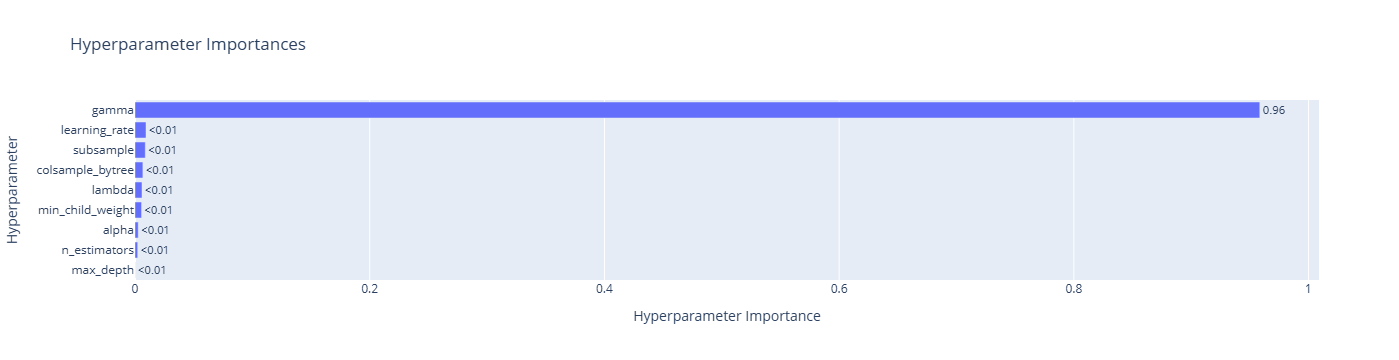

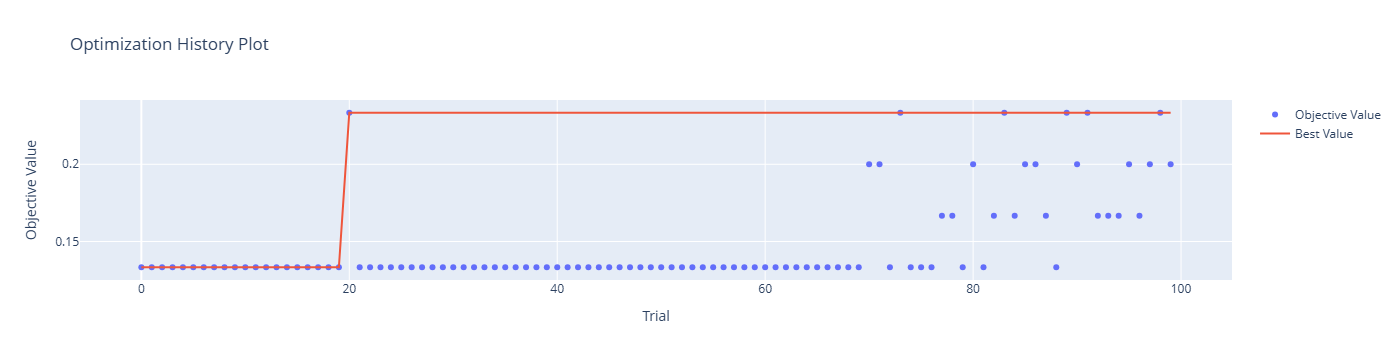

Best trial: 0.23333333333333334
Best params: {'max_depth': 2, 'learning_rate': 0.07838528863639367, 'n_estimators': 809, 'subsample': 0.7241088989848347, 'colsample_bytree': 0.7215828690454005, 'min_child_weight': 11, 'gamma': 0.4486922188413933, 'alpha': 7.53528077716474, 'lambda': 2.095049253811054}
Train Accuracy: 0.38
Test Accuracy: 0.2619047619047619
Prompt 1 Train Accuracy: 0.0
Prompt 1 Test Accuracy: 0.0
Prompt 2 Train Accuracy: 0.0
Prompt 2 Test Accuracy: 0.0
Prompt 3 Train Accuracy: 0.0
Prompt 3 Test Accuracy: 0.0
Prompt 4 Train Accuracy: 0.0
Prompt 4 Test Accuracy: 0.0
Prompt 5 Train Accuracy: 0.0
Prompt 5 Test Accuracy: 0.0
Prompt 6 Train Accuracy: 0.0
Prompt 6 Test Accuracy: 0.0
Prompt 7 Train Accuracy: 0.0
Prompt 7 Test Accuracy: 0.0
Prompt 8 Train Accuracy: 0.0
Prompt 8 Test Accuracy: 0.0
Prompt 9 Train Accuracy: 0.9090909090909091
Prompt 9 Test Accuracy: 0.7777777777777778
Prompt 10 Train Accuracy: 0.8709677419354839
Prompt 10 Test Accuracy: 0.5
Optimizing Layer 1 at Con

In [18]:
with open("results-1.csv", "w+", newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    header = ['Layer', 'Context_Level', 'Train_Accuracy', 'Test_Accuracy']
    prompt_headers = []
    for i in range(1, 11):
        prompt_headers.extend([f"Prompt_{i}_Train_Accuracy", f"Prompt_{i}_Test_Accuracy"])

    header.extend(prompt_headers)
    csv_writer.writerow(header)

for context_level in context_levels[1:]:
    print(f"Optimizing Layer {layer} at Context Level {context_level + 2}")
    cl_hs_array = hidden_states_by_cl[f"cl_{context_level + 2}"]
    curr_label_set = curr_labels[f"cl_{context_level + 2}"]
    # print(cl_hs_array[0].shape)
    # print(cl_hs_array[-1].shape)
    #1x512

    print(np.array(cl_hs_array).shape)
    for hs in range(len(cl_hs_array)):
        cl_hs_array[hs] = cl_hs_array[hs].flatten()

    curr_context_level_hs = np.array(cl_hs_array)
    print(curr_context_level_hs.shape)

    curr_label_set = np.array(curr_label_set)

    unique_ids = sorted(set(curr_label_set))

    if(len(unique_ids) < 10): break
    
    X_train, y_train, X_test, y_test = build_dataset(curr_context_level_hs, curr_label_set)

    X_train_opt, X_valid, y_train_opt, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

    #split into train and test and see how many samples of each class are in the test set (might explain 0.0 acc performance in test set).
    print(pd.Series(y_train).value_counts())
    print(pd.Series(y_test).value_counts())
    print(pd.Series(y_train_opt).value_counts())
    print(pd.Series(y_valid).value_counts())

    print("Train Data Shape: ", X_train.shape)
    print("Test Data Shape: ", X_test.shape)
    print("Optimizer Train Data Shape: ", X_train_opt.shape)

    X_train = cp.array(X_train)
    y_train = cp.array(y_train)
    X_test = cp.array(X_test)
    y_test = cp.array(y_test)

    X_train_opt = cp.array(X_train_opt)
    y_train_opt = cp.array(y_train_opt)
    X_valid = cp.array(X_valid)
    y_valid = cp.array(y_valid)


    study = optuna.create_study(direction="maximize")
    # study = optuna.create_study(
    #     pruner=optuna.pruners.MedianPruner(), 
    #     direction="maximize"
    # )
    # study.optimize(objective, n_trials=100, show_progress_bar=True) # n_jobs=-1
    study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)
    
    display(vis.plot_param_importances(study))
    display(vis.plot_optimization_history(study))
    
    
    print(f"Best trial: {study.best_trial.value}")
    print(f"Best params: {study.best_params}")

    best_params = study.best_params

    classifier = XGBClassifier(**best_params, seed = 42, objective = 'multi:softmax', eval_metric = "merror", num_class = len(unique_ids), tree_method='hist', device='cuda')
    classifier.fit(X_train, y_train)
    preds_train = classifier.predict(X_train)
    preds = classifier.predict(X_test)

    train_accuracy = np.mean(cp.array(preds_train) == y_train)
    accuracy = np.mean(cp.array(preds) == y_test)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {accuracy}")

    prompt_accs = []

    for i in range(10):
        mask = y_test == i
        prompt_test = y_test[mask]
        prompt_preds = cp.array(preds)[mask]
        prompt_test_acc = np.mean(prompt_preds == prompt_test)

        mask_train = y_train == i
        prompt_train = y_train[mask_train]
        prompt_preds_train = cp.array(preds_train)[mask_train]
        prompt_train_acc = np.mean(prompt_preds_train == prompt_train)

        print(f"Prompt {i + 1} Train Accuracy: {prompt_train_acc}")
        print(f"Prompt {i + 1} Test Accuracy: {prompt_test_acc}")

        prompt_accs.append(prompt_train_acc)
        prompt_accs.append(prompt_test_acc)

    
    with open("results-1.csv", "a+", newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',')
        values = [layer, context_level + 2, train_accuracy, accuracy]
        values.extend(prompt_accs)
        csv_writer.writerow(values)
            


    del classifier, X_train, y_train, X_test, y_test, preds

    # XGBoost cleanup
    try:
        booster = classifier.get_booster()
        del booster
    except:
        pass
    
    # CuPy cleanup
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    
    gc.collect()

In [19]:
# # with open("results.csv", "w+", newline='') as csvfile:
# #     csv_writer = csv.writer(csvfile, delimiter=',')
# #     header = ['Layer', 'Context_Level', 'Train_Accuracy', 'Test_Accuracy']
# #     prompt_headers = []
# #     for i in range(1, 11):
# #         prompt_headers.extend([f"Prompt_{i}_Train_Accuracy", f"Prompt_{i}_Test_Accuracy"])

# #     header.extend(prompt_headers)
# #     csv_writer.writerow(header)

# for context_level in context_levels:
#     cl_hs_array = hidden_states_by_cl[f"cl_{context_level + 2}"]
#     curr_label_set = curr_labels[f"cl_{context_level + 2}"]
#     # print(cl_hs_array[0].shape)
#     # print(cl_hs_array[-1].shape)
#     #1x512

#     print(np.array(cl_hs_array).shape)
#     for hs in range(len(cl_hs_array)):
#         cl_hs_array[hs] = cl_hs_array[hs].flatten()

#     curr_context_level_hs = np.array(cl_hs_array)
#     print(curr_context_level_hs.shape)

#     curr_label_set = np.array(curr_label_set)

#     unique_ids = sorted(set(curr_label_set))

#     if(len(unique_ids) < 10): break
    
#     X_train, y_train, X_test, y_test = build_dataset(curr_context_level_hs, curr_label_set)

#     #split into train and test and see how many samples of each class are in the test set (might explain 0.0 acc performance in test set).
#     # print(sorted(set(y_train)))
#     # print(sorted(set(y_test)))
#     print(pd.Series(y_train).value_counts())
#     print(pd.Series(y_test).value_counts())

#     print("Train Data Shape: ", X_train.shape)
#     print("Test Data Shape: ", X_test.shape)
    
#     X_train = cp.array(X_train)
#     y_train = cp.array(y_train)
#     X_test = cp.array(X_test)
#     y_test = cp.array(y_test)

#     classifier = XGBClassifier(seed = 42, objective = 'multi:softmax', eval_metric = "merror", num_class = len(unique_ids), tree_method='hist', device='cuda')
#     classifier.fit(X_train, y_train)
#     preds_train = classifier.predict(X_train)
#     preds = classifier.predict(X_test)

#     train_accuracy = np.mean(cp.array(preds_train) == y_train)
#     accuracy = np.mean(cp.array(preds) == y_test)

#     print(f"Train Accuracy: {train_accuracy}")
#     print(f"Test Accuracy: {accuracy}")

#     prompt_accs = []

#     for i in range(10):
#         mask = y_test == i
#         prompt_test = y_test[mask]
#         prompt_preds = cp.array(preds)[mask]
#         prompt_test_acc = np.mean(prompt_preds == prompt_test)

#         mask_train = y_train == i
#         prompt_train = y_train[mask_train]
#         prompt_preds_train = cp.array(preds_train)[mask_train]
#         prompt_train_acc = np.mean(prompt_preds_train == prompt_train)

#         print(f"Prompt {i + 1} Train Accuracy: {prompt_train_acc}")
#         print(f"Prompt {i + 1} Test Accuracy: {prompt_test_acc}")

#         prompt_accs.append(prompt_train_acc)
#         prompt_accs.append(prompt_test_acc)

    
#     # with open("results.csv", "a+", newline='') as csvfile:
#     #     csv_writer = csv.writer(csvfile, delimiter=',')
#     #     values = [layer, context_level + 2, train_accuracy, accuracy]
#     #     values.extend(prompt_accs)
#     #     csv_writer.writerow(values)
            


#     del classifier, X_train, y_train, X_test, y_test, preds

#     # XGBoost cleanup
#     try:
#         booster = classifier.get_booster()
#         del booster
#     except:
#         pass
    
#     # CuPy cleanup
#     cp.get_default_memory_pool().free_all_blocks()
#     cp.get_default_pinned_memory_pool().free_all_blocks()
    
#     gc.collect()

In [20]:
# for key in curr_labels.keys():
#     print(pd.Series(curr_labels[key]).value_counts())

#     #split into train and test and see how many samples of each class are in the test set (might explain 0.0 acc performance in test set).
#     X_train, y_train, X_test, y_test = build_dataset(curr_context_level_hs, curr_label_set)